<a href="https://www.kaggle.com/code/abhijitbhandari/customer-segmentation-using-transformers?scriptVersionId=169898641" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Finding a Strategy For Choosing the Right Customer

## About the Dataset

There has been a revenue decline in the Portuguese Bank and they would like to know what actions to take. After investigation, they found that the root cause was that their customers are not investing enough for long term deposits. So the bank would like to identify existing customers that have a higher chance to subscribe for a long term deposit and focus marketing efforts on such customers.

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
## import data modelling libraries
from sklearn.preprocessing import LabelEncoder
import missingno as msno

In [3]:
## Read the dataset
df = pd.read_csv("/kaggle/input/banking-dataset-classification/new_train.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


## Features Description

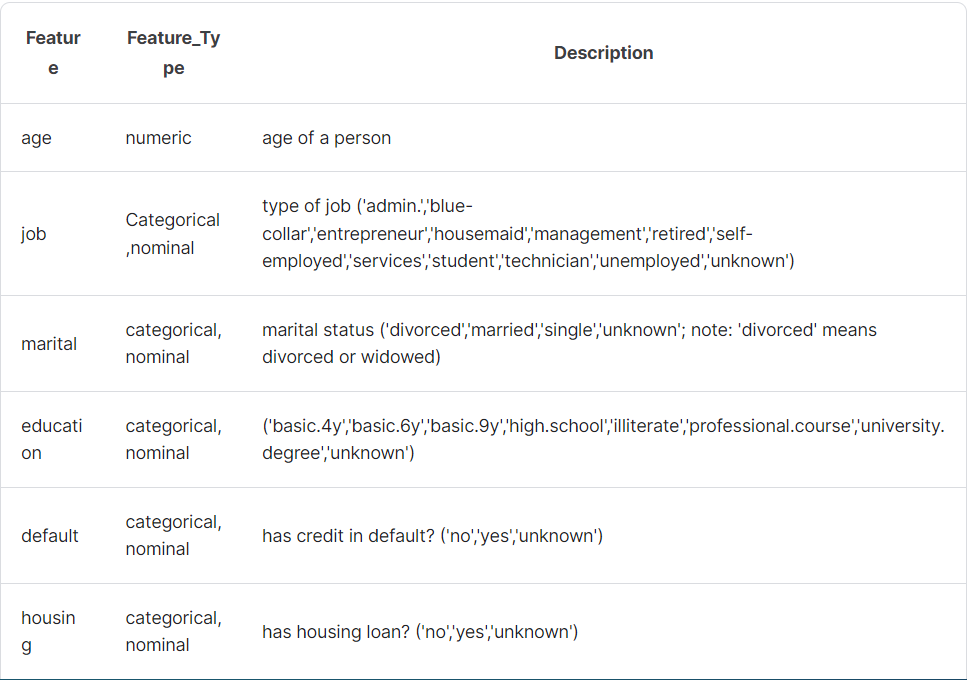

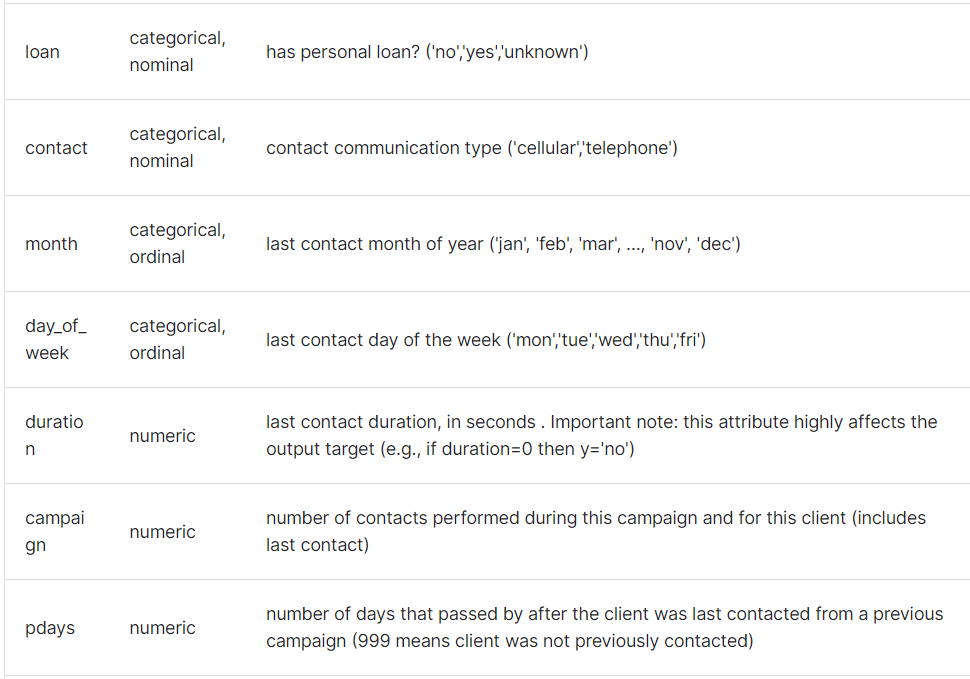

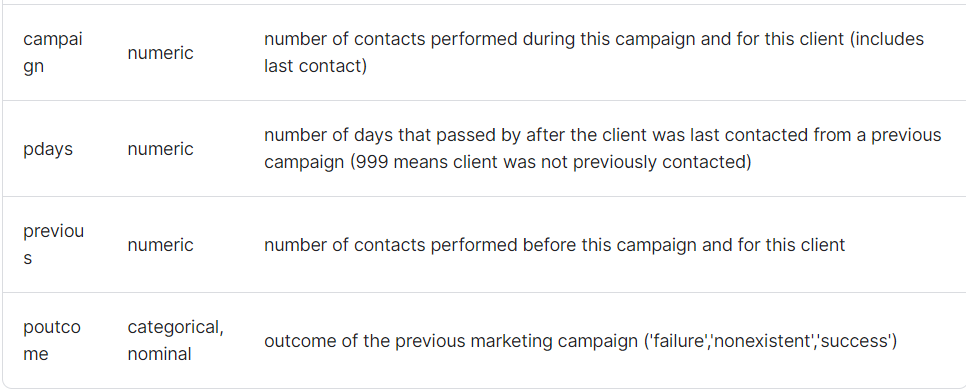

There are 32950 rows and 16 columns in the data
age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object


<Axes: >

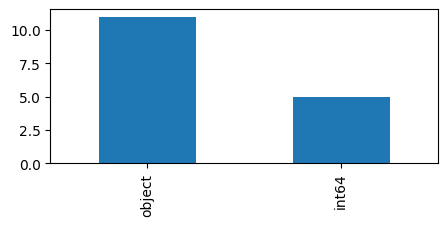

In [4]:
## Checking Data Attributes

print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the data")
print(df.dtypes)
df.dtypes.value_counts().plot(kind = "bar", figsize = (5,2))

From the barplot, we can see that most of the columns are object datatype

The most critical step in data preprocessing involves checking whether any column in the dataset contains null values. Failing to handle null values before feeding the data into a machine learning model can result in inaccurate predictions.

<Axes: >

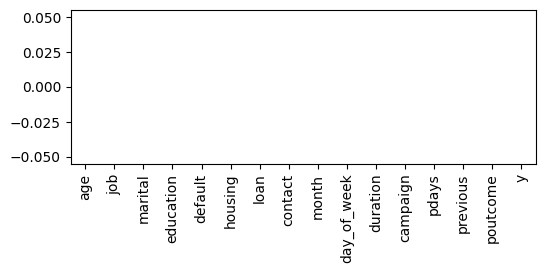

In [5]:
## Checking null values
df.isnull().sum().plot(kind = "bar", figsize = (6,2))

There are no null values in any of the columns present in the dataset

Another significant factor that can lead to model failure is class imbalance. When the dependent column is predominantly populated by one class with very few instances of the other class, the model tends to learn more about the frequently occurring class and may struggle to accurately predict the less frequent class.

Percentage of Yes and No:
 y
no     88.734446
yes    11.265554
Name: count, dtype: float64


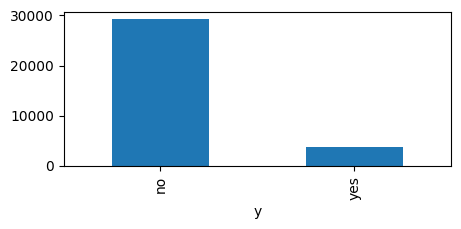

In [6]:
## Check for class imbalance
df["y"].value_counts().plot(kind = "bar", figsize = (5,2))
print("Percentage of Yes and No:\n",(df["y"].value_counts()/len(df))*100)

From the bar plot above, it is evident that nearly 89% of the data pertains to the failure to acquire customers or convince them to subscribe to a term deposit.

## Analyzing the Data

In [7]:
len(plt.colormaps())

178

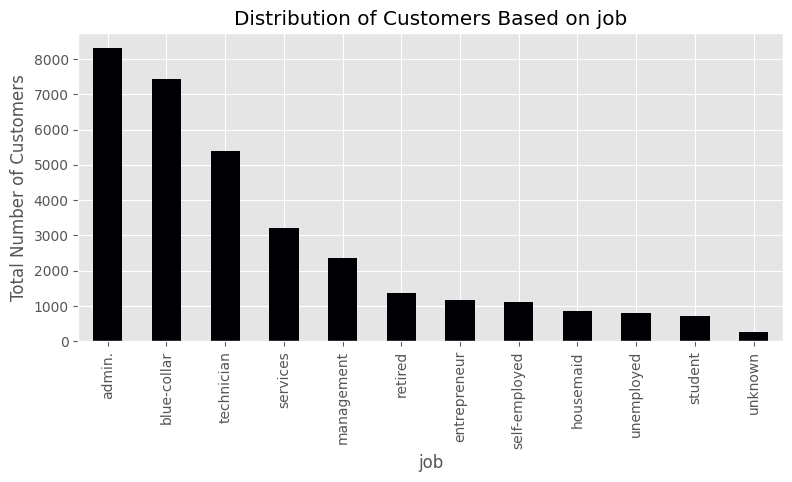

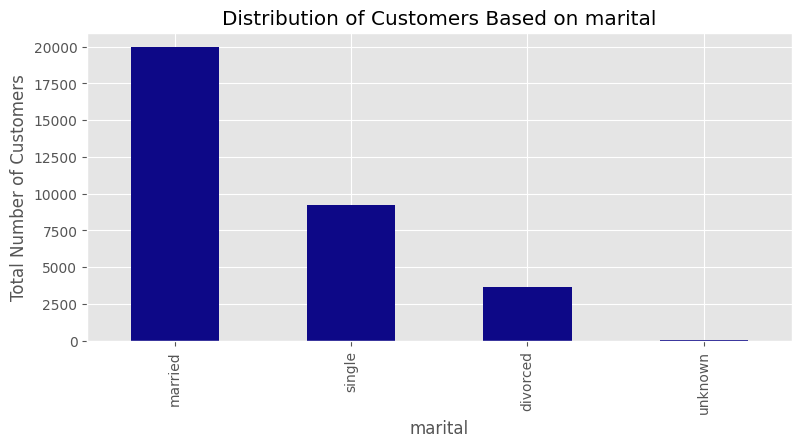

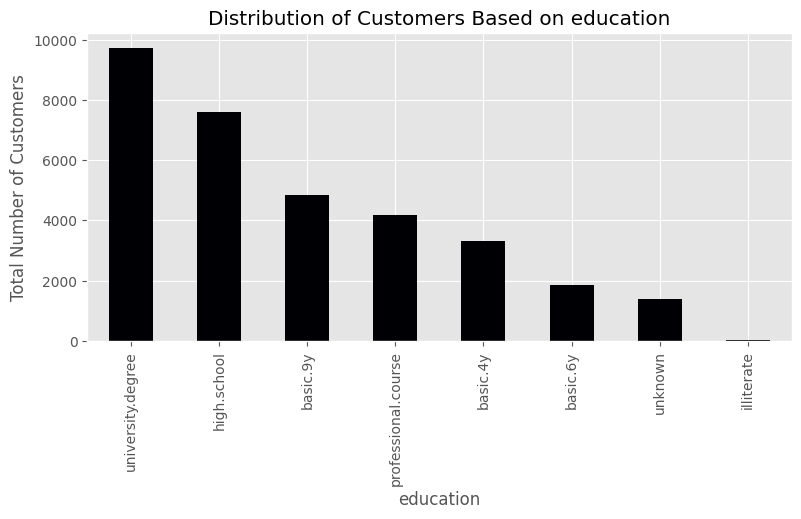

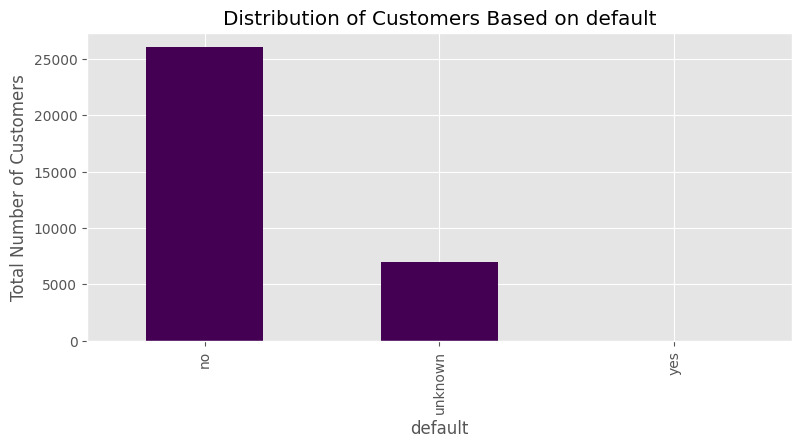

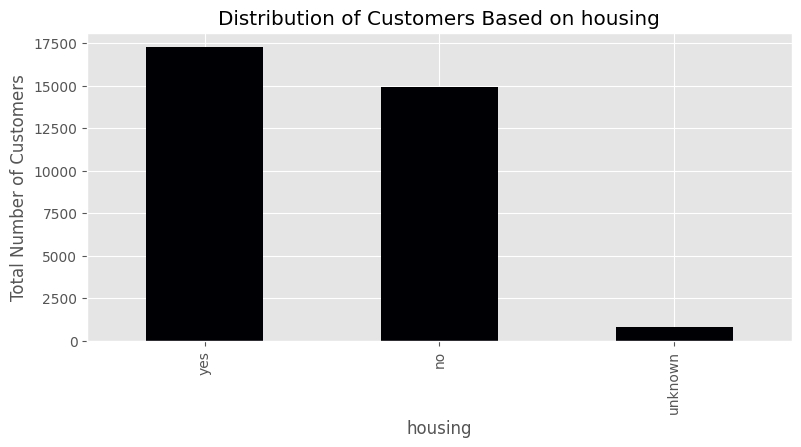

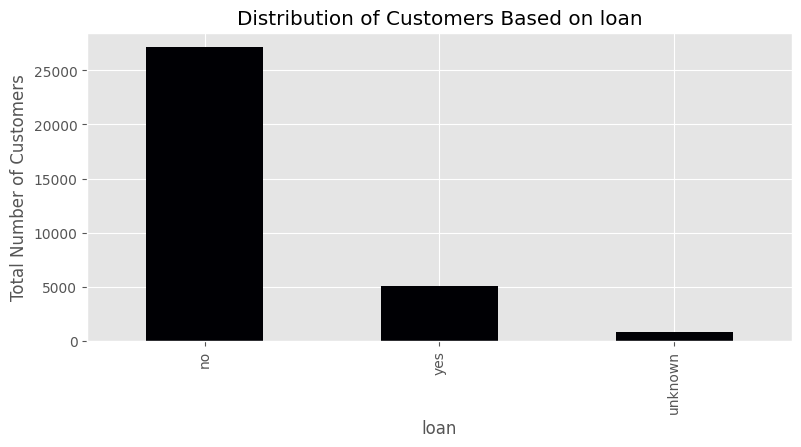

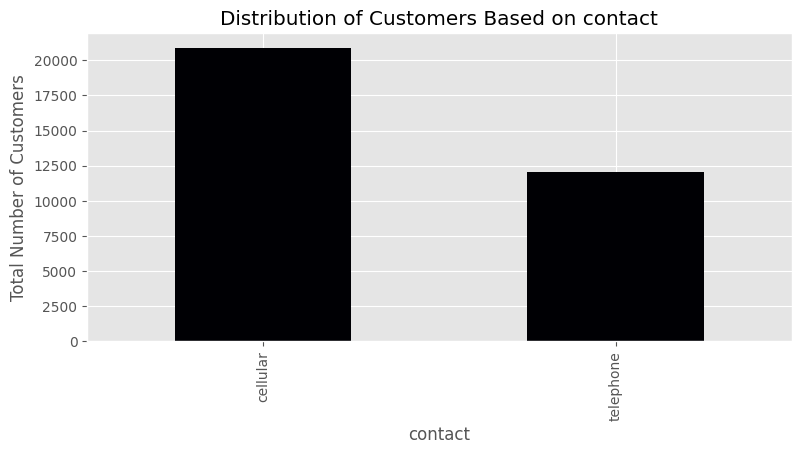

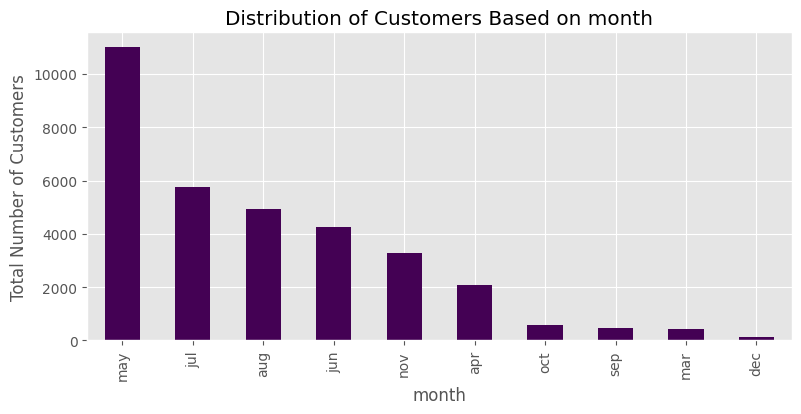

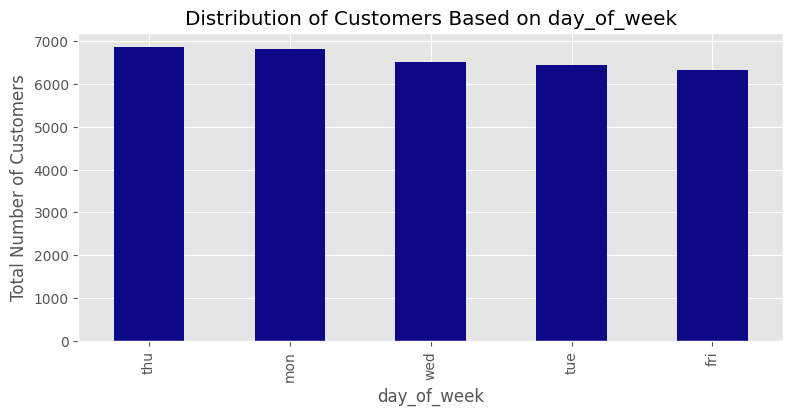

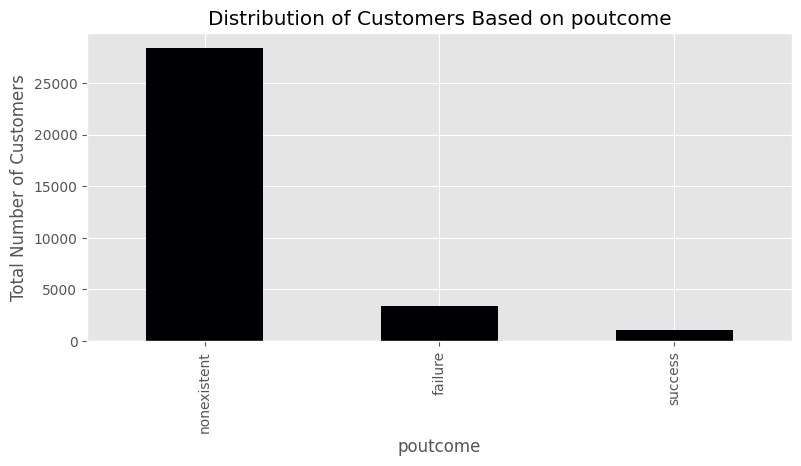

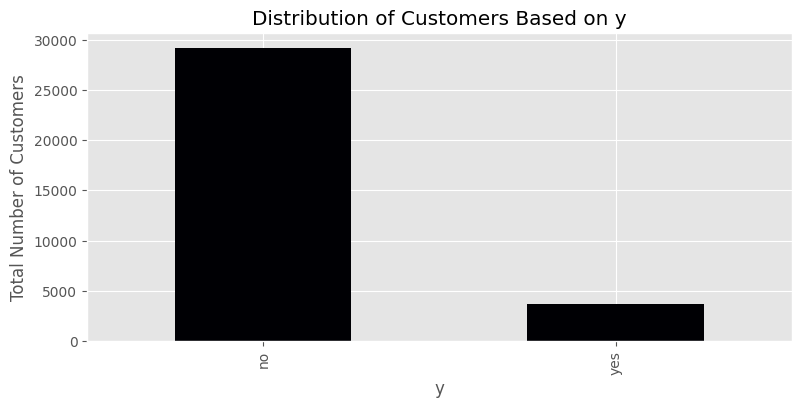

In [8]:
## Understanding the categorical variables



cat_vars = df.select_dtypes(include = "object")
plt.style.use("ggplot")

colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
idx = len(colormaps)

for col in cat_vars.columns:
    random_val = np.random.randint(0, idx)
    plt.figure(figsize = (20,4))
    plt.subplot(121)
    cat_vars[col].value_counts().plot(kind = "bar", 
                                      cmap = colormaps[random_val])
    plt.xlabel(col)
    plt.ylabel("Total Number of Customers")
    plt.title(f"Distribution of Customers Based on {col}")
    
    
    
    

#### Key Observations

* The top three professions among our customers are Administration, Blue-Collar, and Technician.

* A significant portion of our customers are married.

* In terms of education, the majority of customers hold a University Degree.

* Most of our customers are not defaulting on credit.

* The majority of customers have a housing loan but do not have a personal loan.

* According to the Poutcome column, most of the customers contacted this year were not contacted during the last marketing campaign. This indicates that they are entirely new targets.

* A large proportion of customers have not subscribed to a term deposit.

#### Understanding the scenario of null values

We can observe that there are entries labeled as "unknown" in certain columns. Therefore, this "unknown" entry signifies the presence of missing values.

In [9]:
### Handling Missing Values

cols_with_unknown = df.apply(lambda col:col.name if "unknown" in col.values else None).tolist()
cols_with_unknown = [col for col in cols_with_unknown if col is not None]
print("Columns with unknown values: \n",cols_with_unknown)

Columns with unknown values: 
 ['job', 'marital', 'education', 'default', 'housing', 'loan']


In [10]:
print("Percentage of Unknown Field Record in Each Column: \n")
(df.apply(lambda col:col.eq("unknown").sum())/len(df))*100

Percentage of Unknown Field Record in Each Column: 



age             0.000000
job             0.804249
marital         0.197269
education       4.239757
default        21.062215
housing         2.415781
loan            2.415781
contact         0.000000
month           0.000000
day_of_week     0.000000
duration        0.000000
campaign        0.000000
pdays           0.000000
previous        0.000000
poutcome        0.000000
y               0.000000
dtype: float64

#### Determining the Relationship Between Null Values

In [11]:
clone_df = df.copy()
clone_df.replace(to_replace = "unknown", value = np.nan, inplace = True)

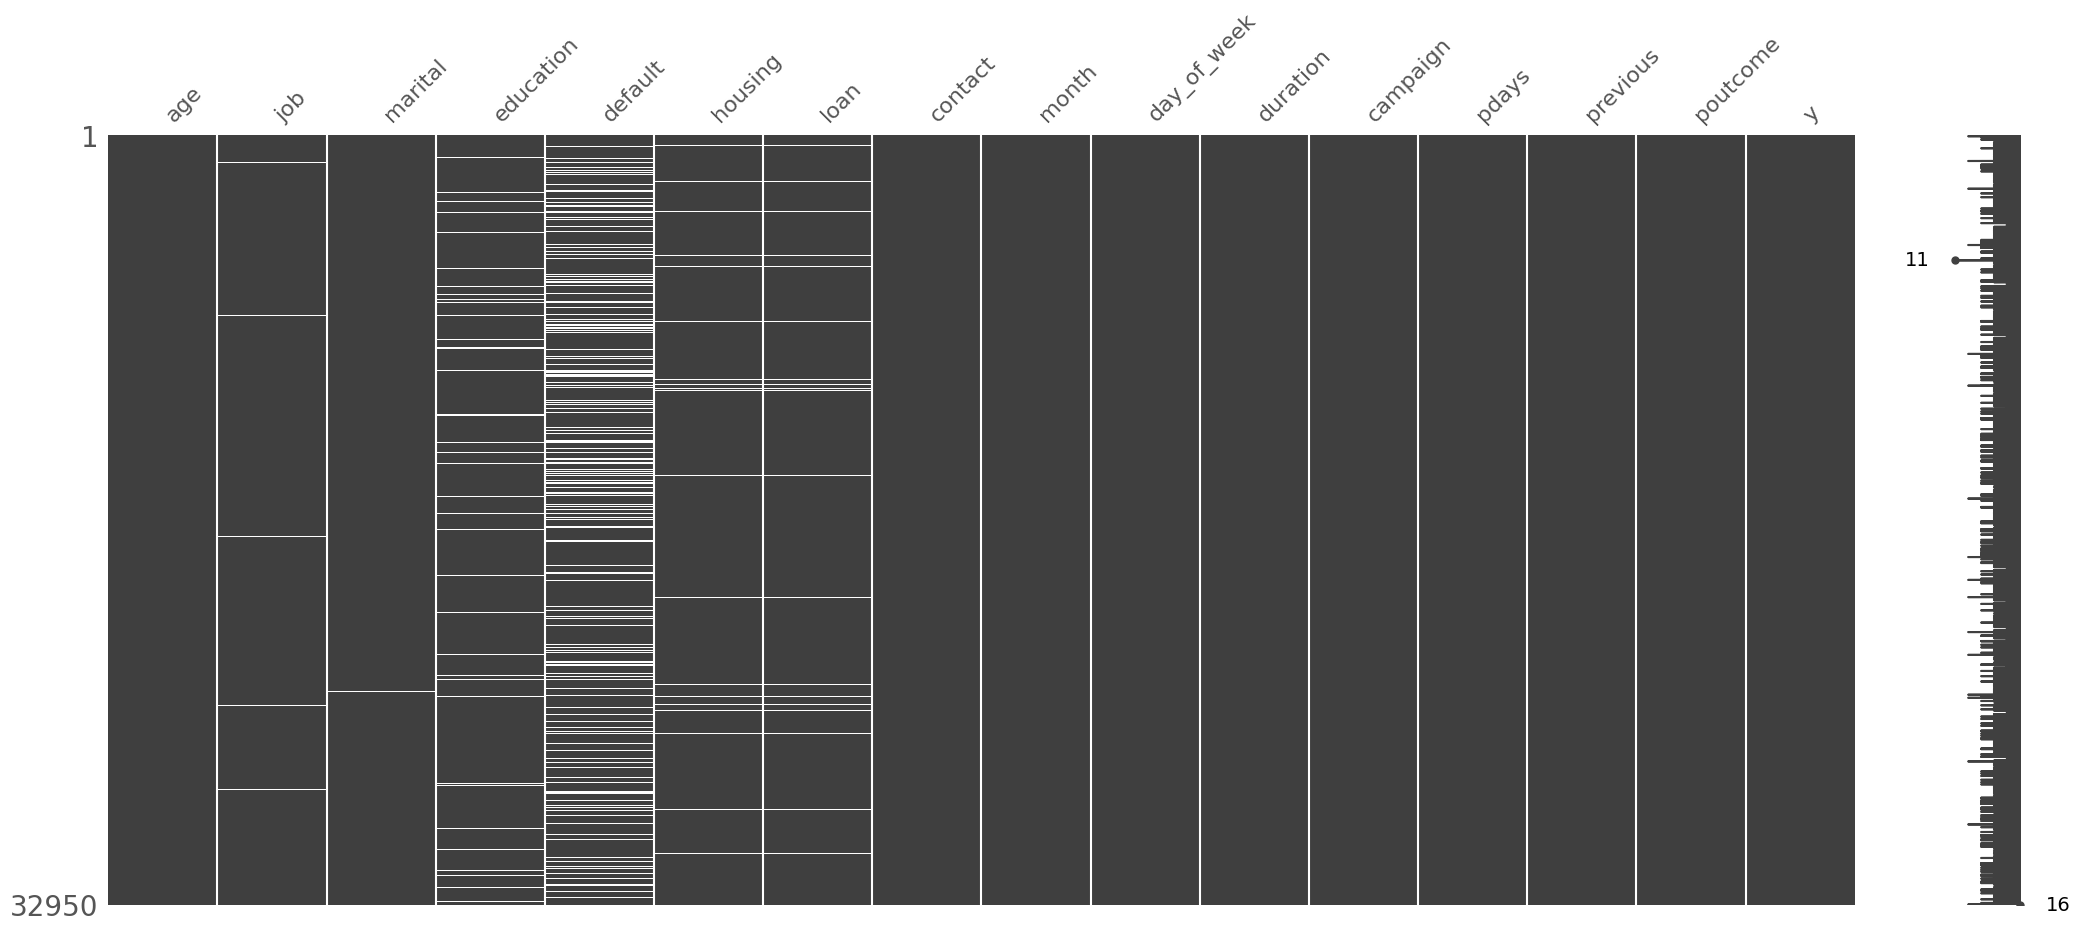

In [12]:
msno.matrix(clone_df)
plt.show()

**Key Observation:**

* We can see that the number of null values in default case is more compact than compared to other columns.

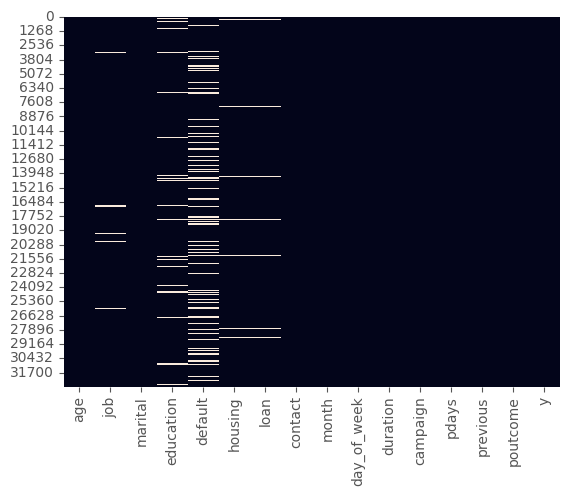

In [13]:
sns.heatmap(clone_df.isnull(), cbar = False)
plt.show()

**Key  Observation**

* In the dataset, whenever a null value appears in the "housing" column, a corresponding null value is also observed in the "loan" column within the same row. This suggests that these instances may represent customers who chose not to disclose whether they had taken any loans. Therefore, it is advisable to retain the unknown value as "unknown" in both of these columns to accurately reflect this missing information.

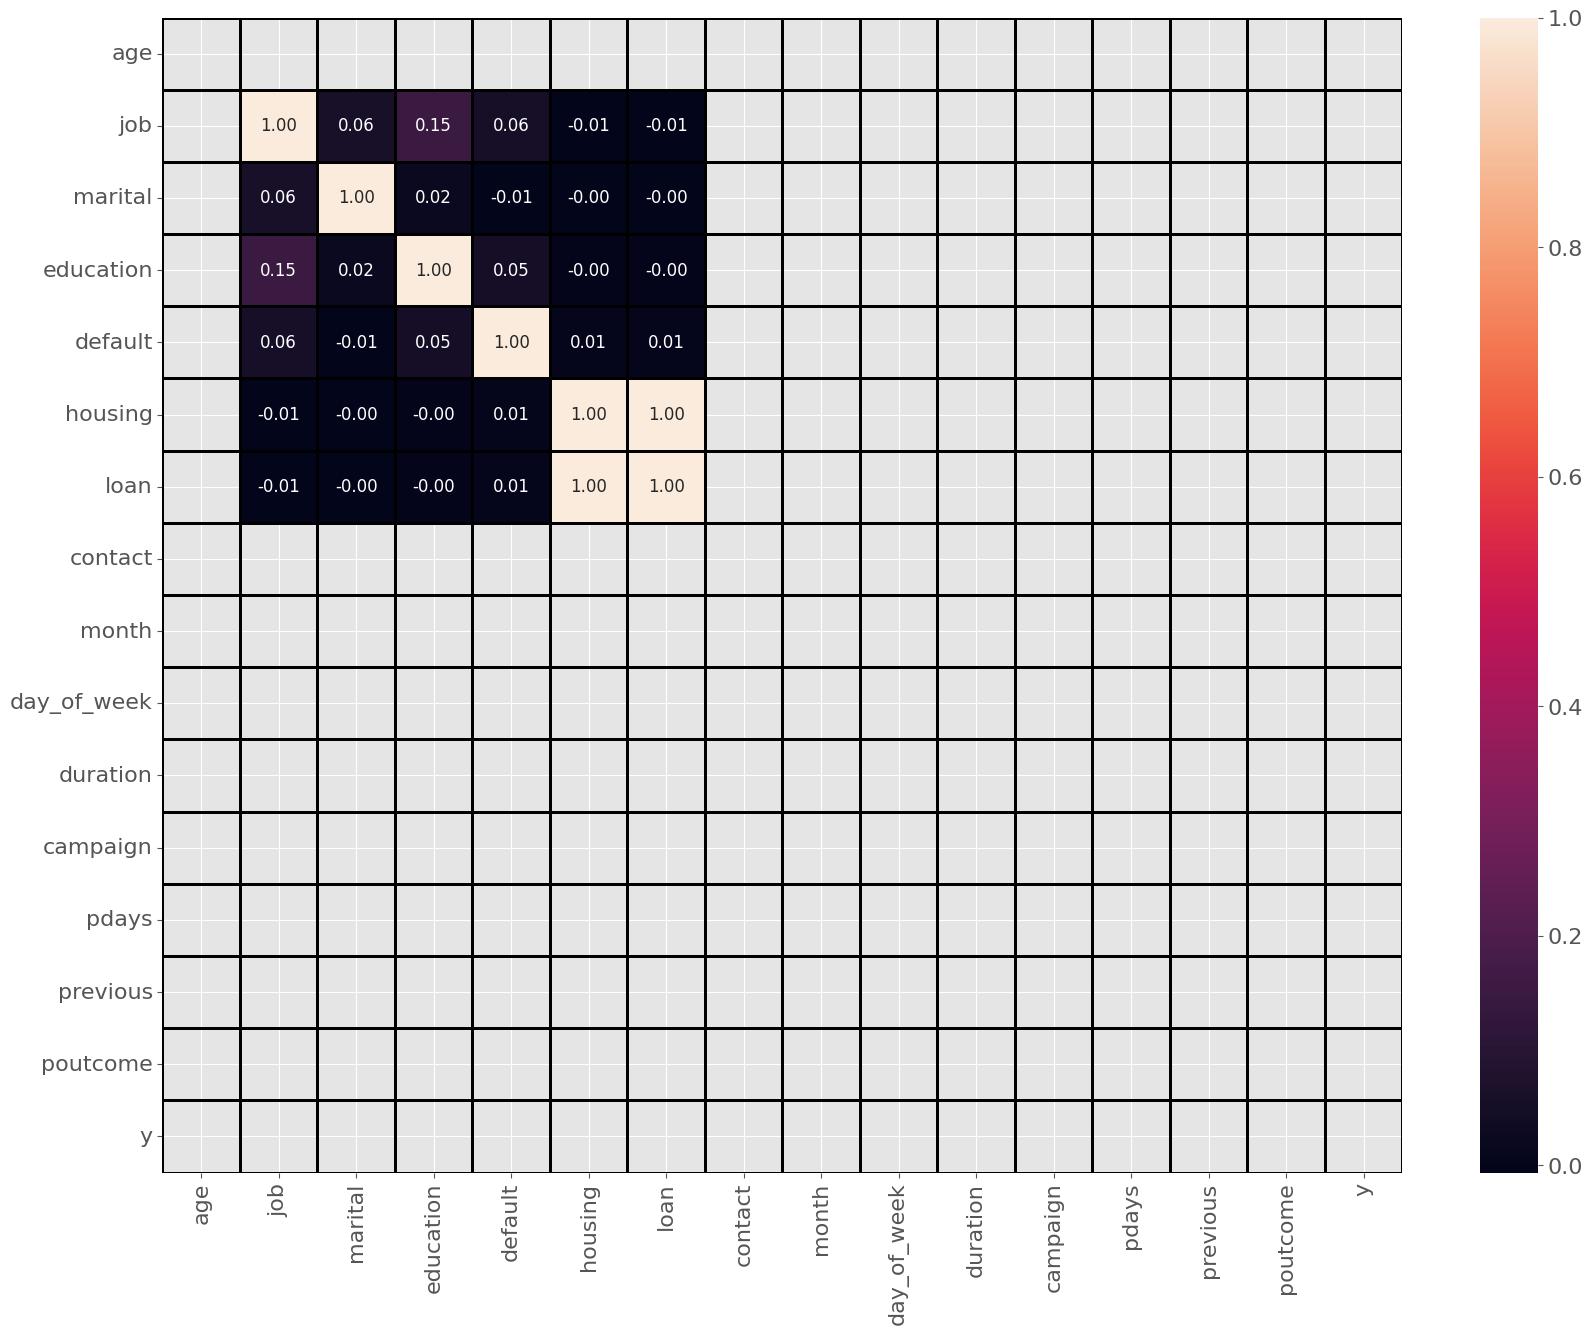

In [14]:
## Calculate correlation between null values

null_corr = clone_df.isnull().corr()
plt.figure(figsize = (20,15))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
heatmap = sns.heatmap(null_corr, 
            linecolor = "black", 
            linewidth = 1, 
            annot = True, 
            fmt = ".2f",
           annot_kws = {"fontsize":12})
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize = 16)

plt.show()

**Key Observations**

* In addition to "housing" and "loan" columns, no significant correlation was observed among the null values in the remaining columns of the dataset.

**Handling Null Value** 

Given that we haven't identified a suitable strategy to replace the null values in the dataset, we will retain the "unknown" value as it is for these missing entries.

## Analyzing the Numerical Columns

In [15]:
## Analysing numerical cols
numeric_cols = df.select_dtypes(include = np.number)
numeric_cols.head()

,age,duration,campaign,pdays,previous
0,49,227,4,999,0
1,37,202,2,999,1
2,78,1148,1,999,0
3,36,120,2,999,0
4,59,368,2,999,0


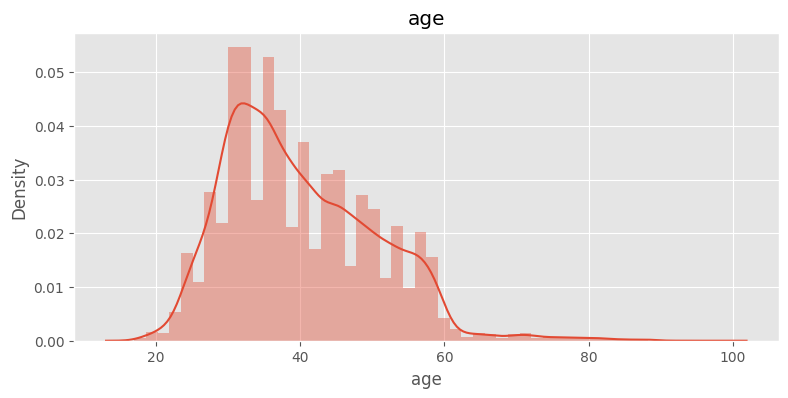

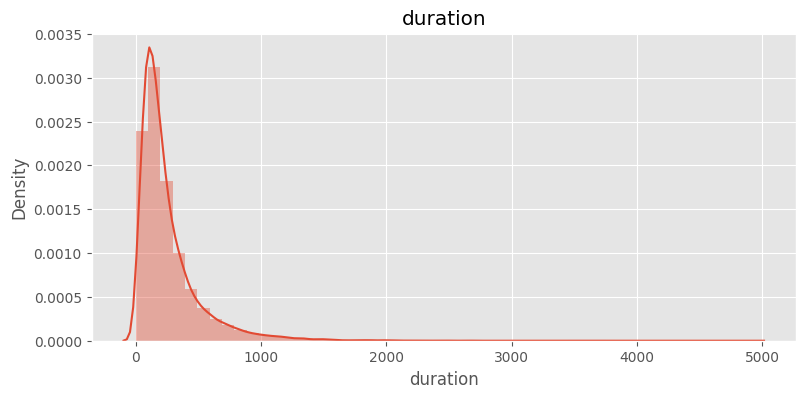

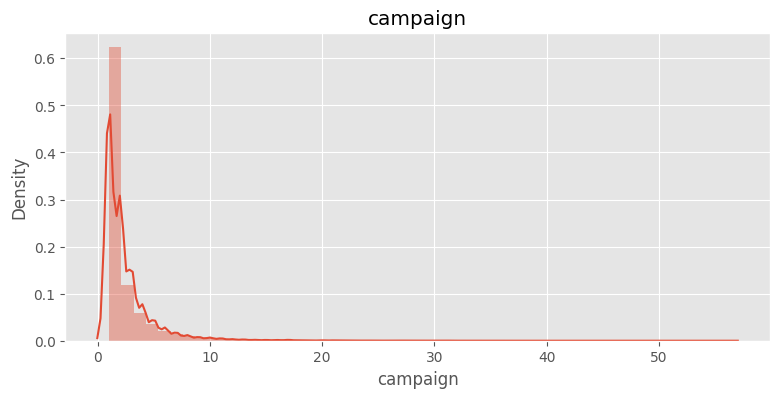

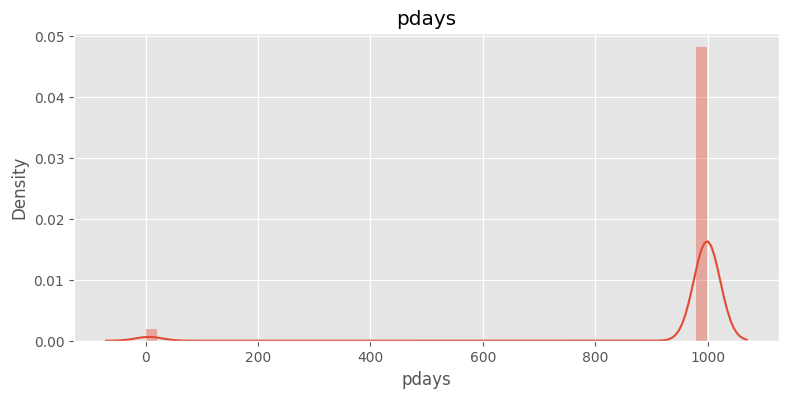

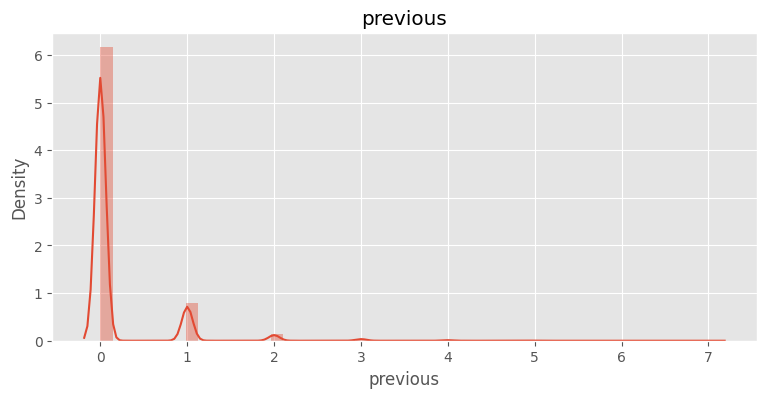

In [16]:
## Cchecking data distribution
plt.style.use("ggplot")
for cols in numeric_cols.columns:
    plt.figure(figsize = (20,4))
    plt.subplot(121)
    sns.distplot(numeric_cols[cols], kde = True)
    plt.title(cols)

**Key Observations**

* The data indicates that a significant portion of customers are in their thirties, and the age distribution is right-skewed. Consequently, the mode and median values precede the mean in this dataset.

* The duration and campaign are also heavily skewed.

* The majority of customers are being contacted for the first time, as indicated by the prevalence of the value 999 in the "pdays" column. According to the feature description, a value of 999 represents customers who are being contacted for the first time.

* Given that the "pdays" value is 999, it's evident that the number of contacts performed previously with that client would be zero, as indicated by the distribution of the "previous" variable, which also reflects a similar trend.



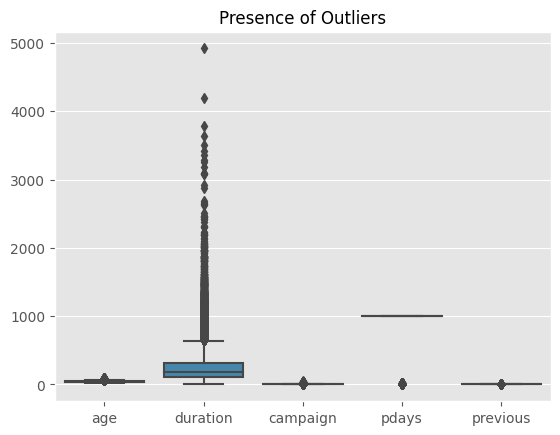

In [17]:
sns.boxplot(numeric_cols)
plt.title("Presence of Outliers", fontsize = 12)
plt.show()

**Key Observation**

* The number of outliers in duration column is pretty high.

age           108.0
duration    67069.0
campaign        8.0
pdays       35326.0
previous        0.0
dtype: float64


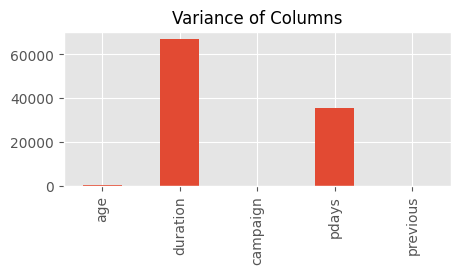

In [18]:
print(numeric_cols.var().round())
numeric_cols.var().plot(kind = "bar", figsize = (5,2))
plt.title("Variance of Columns", fontsize = 12)
plt.show()

age           75
duration    1467
campaign      40
pdays         27
previous       8
dtype: int64


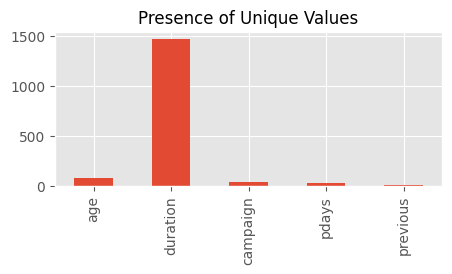

In [19]:
print(numeric_cols.nunique())
numeric_cols.nunique().plot(kind = "bar", figsize = (5,2))
plt.title("Presence of Unique Values", fontsize = 12)
plt.show()

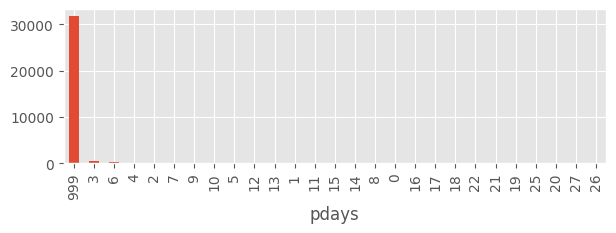

In [20]:
numeric_cols["pdays"].value_counts().plot(kind = "bar",figsize = (7,2))
plt.show()

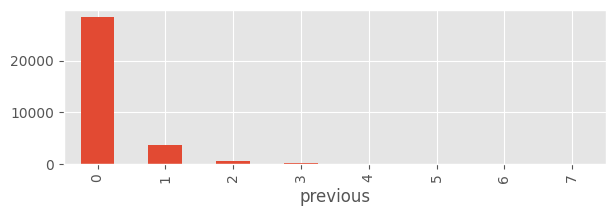

In [21]:
numeric_cols["previous"].value_counts().plot(kind = "bar", figsize = (7,2))
plt.show()

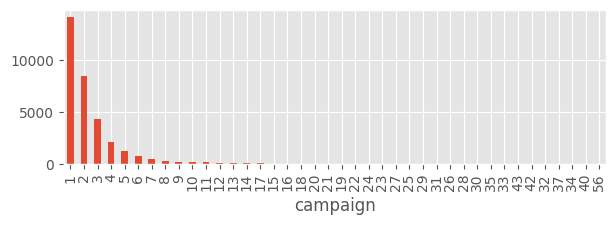

In [22]:
numeric_cols["campaign"].value_counts().plot(kind = "bar", figsize = (7,2))
plt.show()

**Key Observations**

* From the variance and presence of unique values plots, we can see that the pdays and previous columns which are dependent to each other don't have many unique values which can contribute to prediction. So, we decide to drop the two columns.

In [23]:
## Dropping pdays and previous columns
df.drop(["pdays", "previous"], axis = 1, inplace = True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,nonexistent,no


In [24]:
## Final Columns
final_cols = df.columns
final_cols


Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'poutcome',
       'y'],
      dtype='object')

## Bivariate Analysis

In [25]:
cat_vars.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,nonexistent,no
1,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,failure,no
2,retired,married,basic.4y,no,no,no,cellular,jul,mon,nonexistent,yes
3,admin.,married,university.degree,no,yes,no,telephone,may,mon,nonexistent,no
4,retired,divorced,university.degree,no,no,no,cellular,jun,tue,nonexistent,no


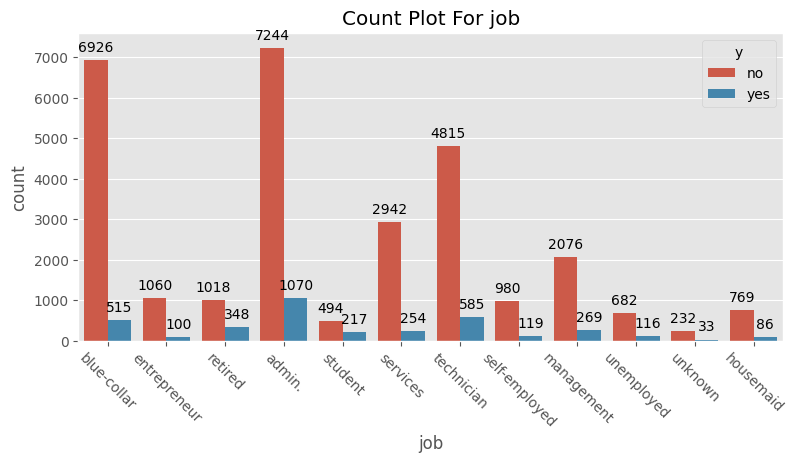

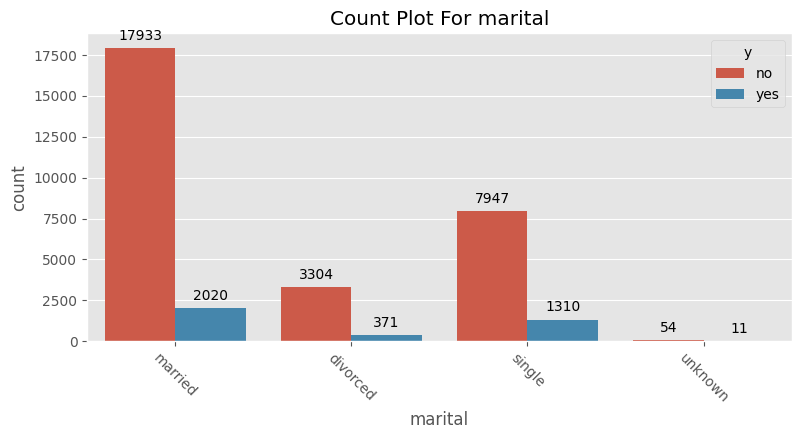

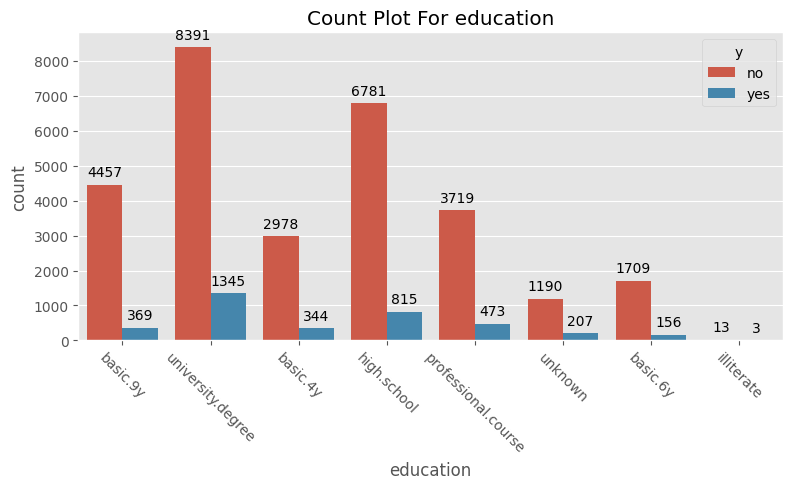

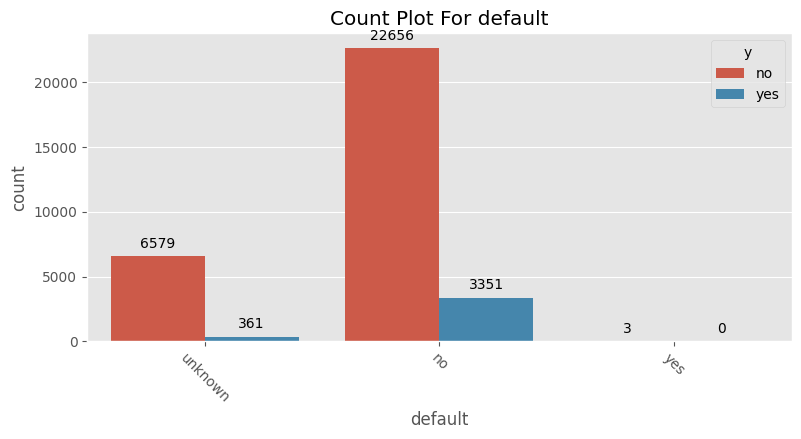

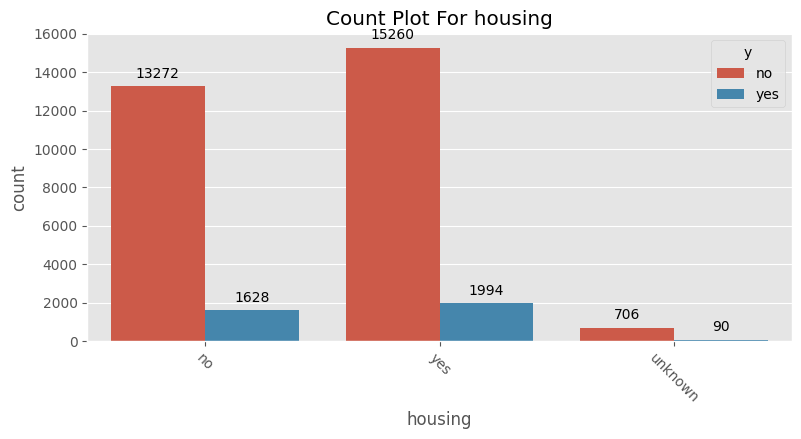

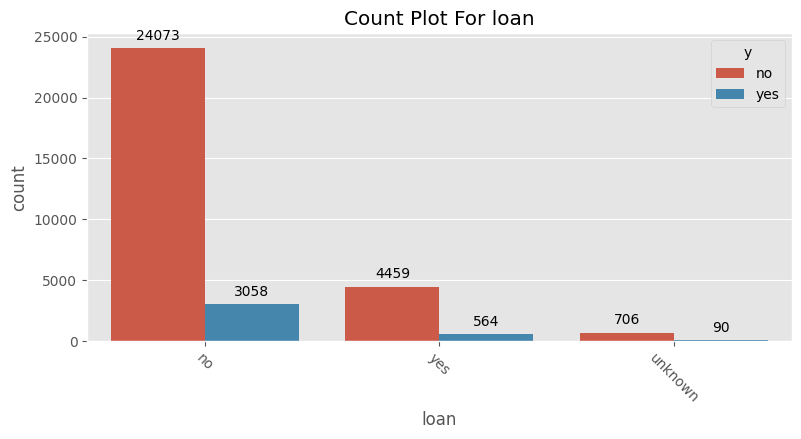

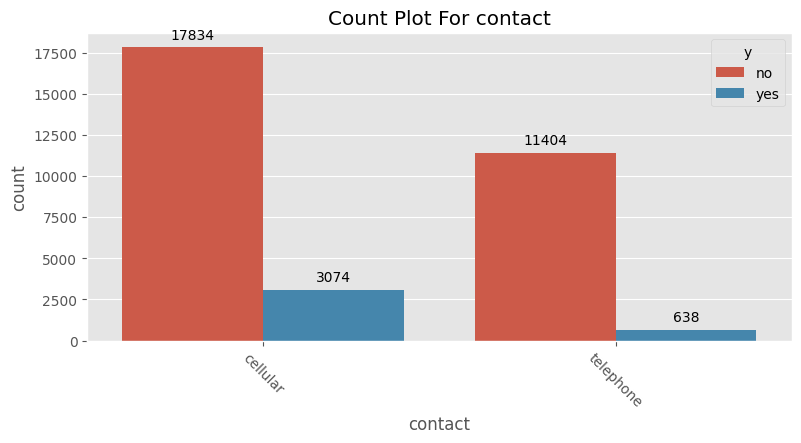

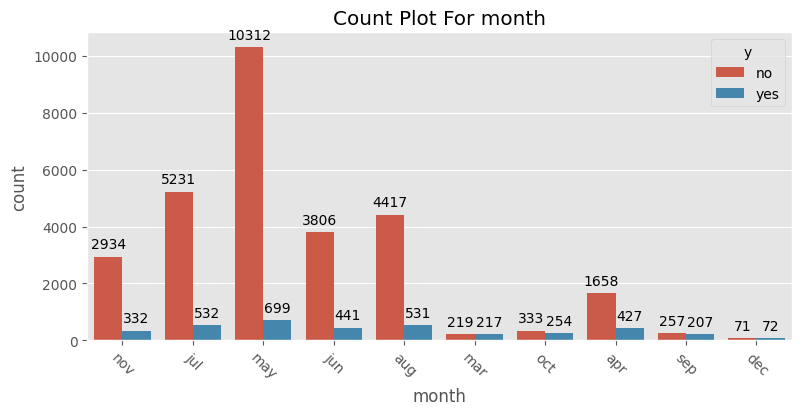

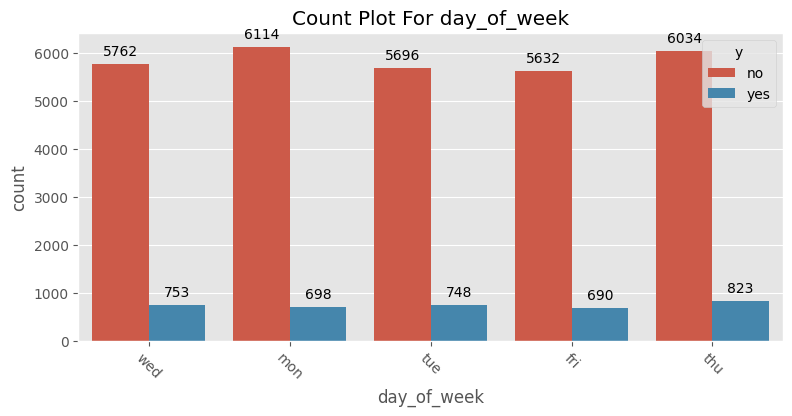

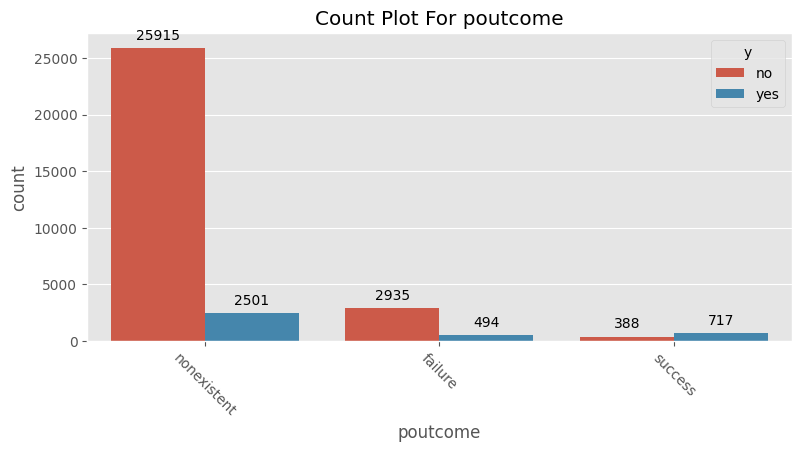

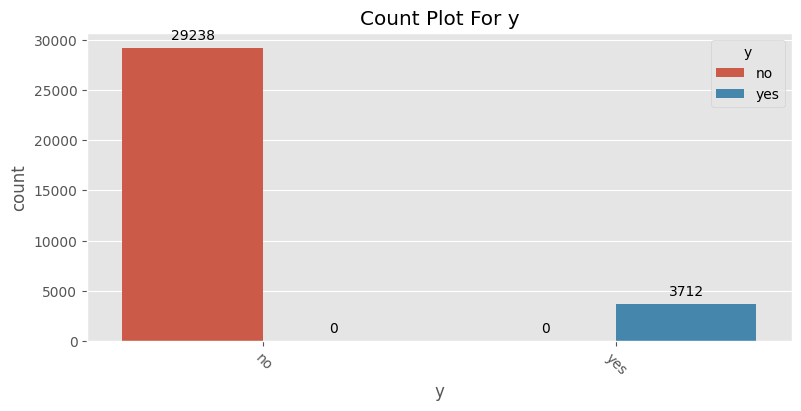

In [26]:
plt.style.use("ggplot")
for col in cat_vars.columns:
    plt.figure(figsize = (20,4))
    plt.subplot(121)
    ax = sns.countplot(x = df[col], hue = df["y"])
    plt.title(f"Count Plot For {col}")
    plt.xticks(rotation = -45)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), ".0f"),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = "center",
                   va = "center",
                   xytext = (0,9),
                   textcoords = "offset points")
    plt.show()

**Key Observations:**

* Customers in administrative jobs have the highest subscription rate for term deposits.

* These customers are typically married individuals.

* They typically hold a university degree.

* Non-defaulters show a higher tendency to subscribe to term deposits.

* The presence of a housing loan does not notably impact the likelihood of subscribing to a term deposit. However, individuals with personal loans are less likely to subscribe, indicating a significant difference in success rates between those with personal loans and those without.

* Customers contacted via cellular communication methods are more inclined to subscribe.

* Contacting customers between April and August increases the likelihood of subscription.

* The day of the week does not significantly affect the subscription rate.

### Understanding the Success Rates in Different Categories

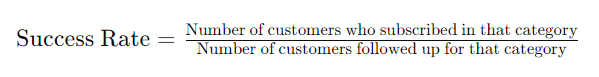

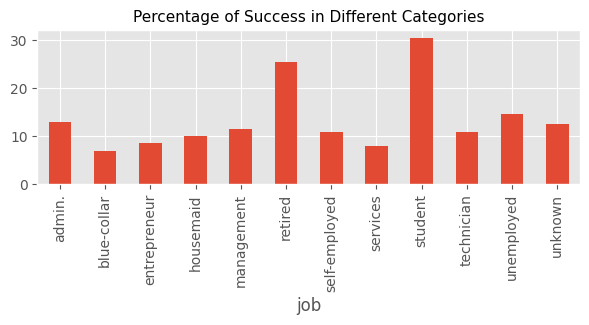

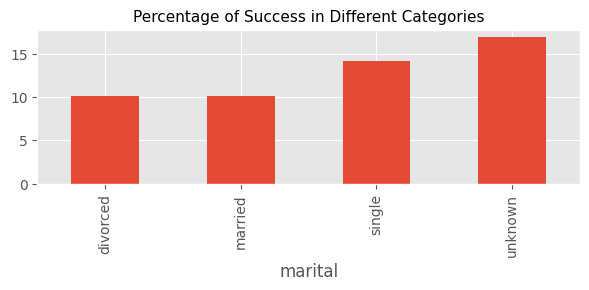

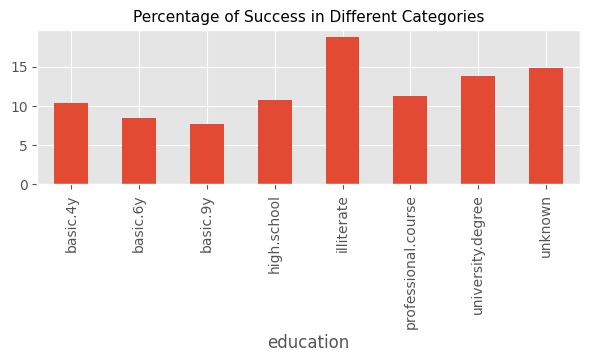

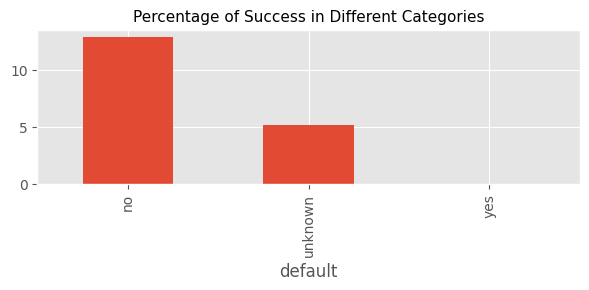

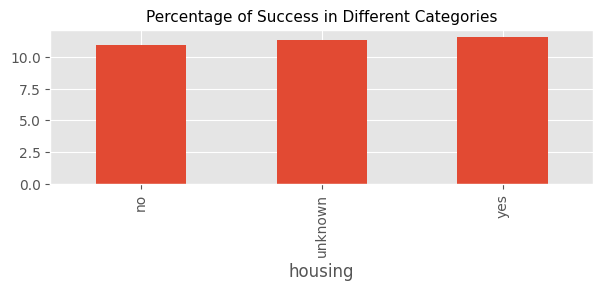

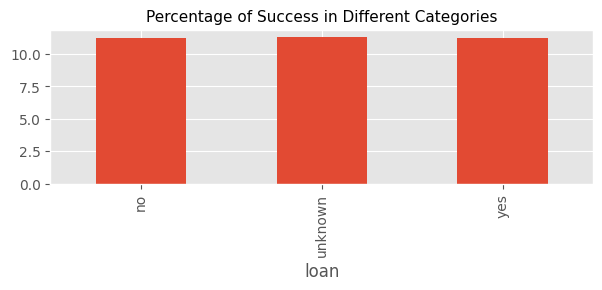

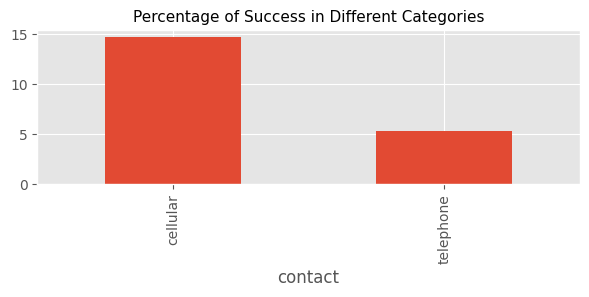

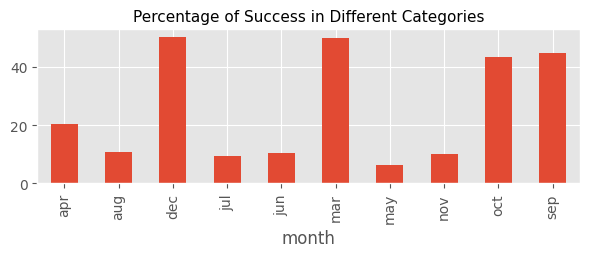

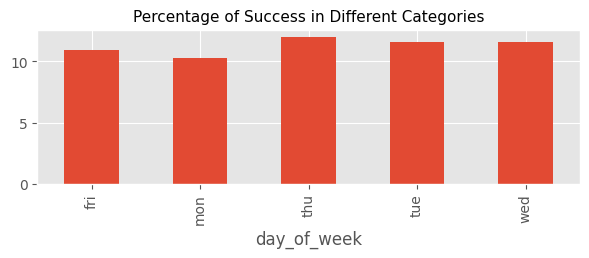

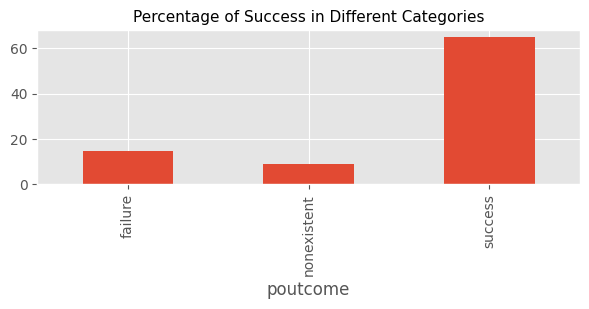

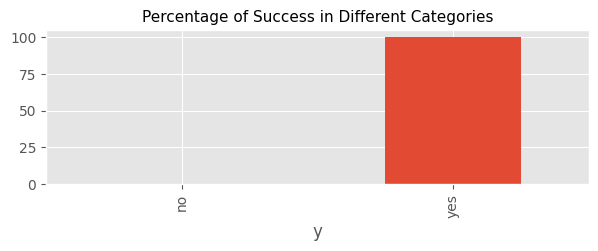

In [27]:
##Understanding the success rate
plt.style.use("ggplot")
for cols in cat_vars.columns:
    subscription_percentage = cat_vars.groupby(cols)["y"].apply(lambda x: float(f"{(x == 'yes').mean()*100:.2f}"))
    subscription_percentage.plot(kind = "bar", figsize = (7,2))
    plt.title("Percentage of Success in Different Categories", fontsize = 11)
    plt.show()
    

**Key Observations:**

* The success rate among students and retired individuals is notably high compared to other categories. Therefore, they should be targeted as potential customers.

* Regarding marital status, the success rate is particularly high for single individuals and those with an unknown marital status.

* The success rate is also high among illiterate individuals.

* In terms of months, the success rate is higher in March, September, October, and December.

## Key Observations Till Now:


**Customer Profile:**

* Top three professions: Administration, Blue-Collar, Technician.
* Majority are married with a University Degree.
* Non-defaulters with housing loans but no personal loans.
* New targets for marketing campaigns.
* Majority have not subscribed to a term deposit.

**Missing Data & Correlation:**

* Null values in "housing" and "loan" columns suggest undisclosed loan status.
* No significant correlation observed among null values in other columns.

**Age and Contact Details:**

* Majority of customers are in their thirties.
* Right-skewed age distribution with high outliers in duration.
* Most customers are first-time contacts (pdays value of 999).

**Term Deposit Subscription:**

* Administrative jobs have the highest subscription.
* Married, university degree holders show higher subscription tendency.
* Non-defaulters and cellular contacts more likely to subscribe.
* Months of March, September, October, December have higher subscription rates.

**Success Rates (Successful subscription / Total Calls Made for that Category):**

* Students and retired individuals have notably high subscription rates.
* Single and unknown marital status customers show higher success rates.
* Success rate is also high among illiterate individuals.
.



### Handling the Outliers

Outliers are data points that deviate significantly from the majority of the dataset, potentially arising from errors, natural variations, or rare events, and they can impact statistical measures and predictive model performance.

We need to handle the outliers to facilitate our machine learning model to be able to generalize the context

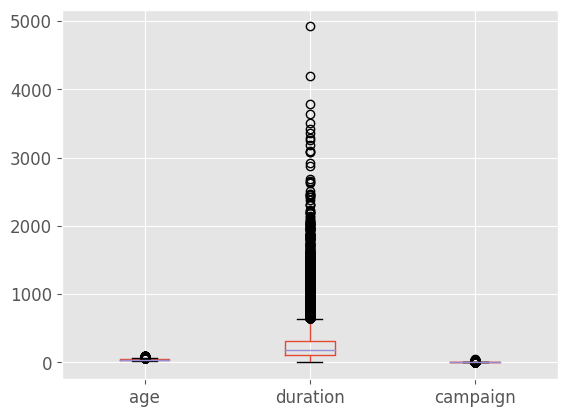

In [28]:
plt.style.use("ggplot")
plt.subplot(111)
df.boxplot()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

**Key Observation:**

* Duration, Age and Campaign are numerical columns.
* All three of them have outliers with duration with the maximum number of outliers

**Replacing Outliers with Upper Quartile and Lower Quartile Values**

In [29]:
for col in df.select_dtypes(np.number):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    if lower_bound>0:
        df.loc[(df[col]<lower_bound) & (df[col]>0), col] = lower_bound
    if upper_bound>0:
        df.loc[(df[col]>upper_bound) & (df[col]>0), col] = upper_bound
    
    print(f"The lower bound for {col} is {lower_bound} \
    and the upper bound is {upper_bound}")
    
    

The lower bound for age is 9.5     and the upper bound is 69.5
The lower bound for duration is -221.0     and the upper bound is 643.0
The lower bound for campaign is -2.0     and the upper bound is 6.0


We have opted against replacing outliers that fall below the lower boundary in the 'duration' and 'campaign' columns. This decision is based on the fact that the lower bound value is negative.

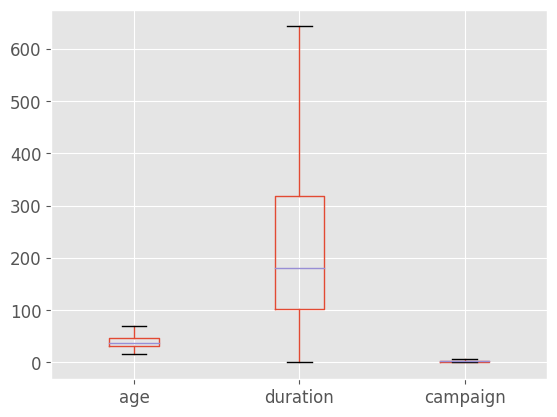

In [30]:
plt.style.use("ggplot")
plt.subplot(111)
df.boxplot()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Customer Segmentation Using LLM + K-Means

**Some portion of the code is taken from [Mastering Customer Segmentation with LLM by Damian Gil](https://towardsdatascience.com/mastering-customer-segmentation-with-llm-3d9008235f41#3a33) and [Hugging Face Sentence Transformer](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L12-v2)**

In [31]:
#Install the Sentence Transformers library
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.4 MB/s eta 0:00:00


In [32]:
from sentence_transformers import SentenceTransformer

In [33]:
def compile_text(x):

    text =  f"""Age: {x['age']},
    Job: {x['job']},
    Marital: {x['marital']},
    Education: {x['education']},
    Default: {x['default']},
    Housing Loan: {x['housing']},
    Personal loan: {x['loan']},
    Contact: {x['contact']},
    Month: {x['month']},
    Day: {x['day_of_week']},
    Duration: {x['duration']},
    Campaign: {x['campaign']},
    Poutcome: {x['poutcome']}"""

    return text

In [34]:
sentences = df.apply(lambda x:compile_text(x), axis = 1).tolist()

## Embedding the sentences

model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L12-v2")
output = model.encode(sentences = sentences, 
                      show_progress_bar = True, 
                      normalize_embeddings = True)
df_embedding = pd.DataFrame(output)
df_embedding.head()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1030 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.021428,0.110901,0.011645,0.014865,-0.023274,0.021947,0.026403,0.016645,-0.098162,-0.024013,...,0.032103,0.008833,0.039013,0.051606,-0.017546,0.022081,-0.009284,-0.104602,-0.031701,-0.023886
1,0.048258,0.112014,0.018530,0.030307,-0.008465,0.015932,0.058563,0.048335,-0.070866,-0.018784,...,0.052046,0.008519,0.025203,0.078874,-0.062254,0.025457,0.040008,-0.064541,-0.008710,0.003428
2,0.016670,0.113963,0.042095,-0.016328,-0.024111,0.016084,0.049274,0.083565,-0.066561,-0.020102,...,0.037639,-0.002904,0.021799,0.067080,-0.026039,0.015130,0.017736,-0.073619,-0.030190,-0.014608
3,0.048615,0.081578,0.036528,0.015308,-0.004190,0.019894,0.045024,0.061225,-0.060219,-0.021926,...,0.036143,0.015287,0.028601,0.063196,-0.043412,0.048990,0.014214,-0.067348,-0.020961,-0.016315
4,0.037976,0.153941,0.038745,0.002067,-0.017661,0.011623,0.063241,0.064772,-0.070638,-0.030683,...,0.019804,0.003323,0.017430,0.084023,-0.038015,0.020062,0.031588,-0.084918,-0.052603,0.003739


## Using PCA to Reduce the Number of Columns in the Embedded Dataframe

In [35]:
## Importing Required Libraries
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [36]:
## Encoding yes to 1 and not to 0
y_train = df["y"].apply(lambda x: 1 if x == "yes" else 0).tolist()

In [37]:
## Creating a pipeline
pipe = Pipeline([
    ("pca", PCA()),
    ("classifier", LogisticRegression())
])

## Define the parameters for pca

param_grid = {"pca__n_components": [30, 50, 80, 100, 150, 180, 200, 250]
             }


## Define Kfold

kfold = StratifiedKFold(n_splits = 5, 
                        shuffle = True, 
                        random_state = 42)


## Perform Gridsearch

grid_search = GridSearchCV(pipe, 
                           param_grid = param_grid,
                           cv = kfold,
                           n_jobs = -1)


grid_search.fit(df_embedding, y_train)

best_n_comps = grid_search.best_params_["pca__n_components"]

print(f"The best number of components is {best_n_comps}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

The best number of components is 100


In [38]:
pca = PCA(n_components = best_n_comps)
pca.fit(df_embedding)

pca_comps = pca.transform(df_embedding)

pca_df = pd.DataFrame(data = pca_comps, columns = [f"PC{i+1}" for i in range(best_n_comps)])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,0.124059,0.157171,0.043713,0.022459,-0.064450,0.072610,0.061706,-0.049525,-0.014964,-0.009979,...,-0.005123,0.003703,0.007719,0.002851,0.004987,-0.001326,-0.005139,0.007317,0.000247,0.000522
1,-0.082248,-0.193709,-0.011548,-0.013015,-0.012794,-0.008294,0.196762,0.182178,-0.102196,0.134391,...,-0.000577,-0.002991,-0.003849,0.010942,0.002937,-0.002829,0.000330,0.001582,0.002687,0.003485
2,-0.029972,0.067576,-0.043937,0.001652,-0.075131,-0.047233,0.001655,-0.108354,-0.050816,0.058817,...,-0.000006,-0.000329,-0.001711,-0.001188,0.003502,-0.003344,-0.002124,0.001160,0.000063,-0.000140
3,0.034605,-0.185133,-0.080625,-0.015489,0.032372,0.078453,-0.045749,0.027520,0.038735,0.011611,...,-0.002209,-0.000373,-0.004446,-0.003677,-0.003562,-0.001311,-0.000094,-0.001042,-0.001969,-0.002120
4,-0.123283,0.026459,-0.046528,0.012895,-0.086217,0.014484,0.129881,-0.057166,-0.064807,-0.013663,...,0.002532,0.000985,-0.002500,-0.004257,-0.009350,0.002102,0.004188,0.001833,0.001646,0.000334


### Loading Libraries Required For Clustering

In [39]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

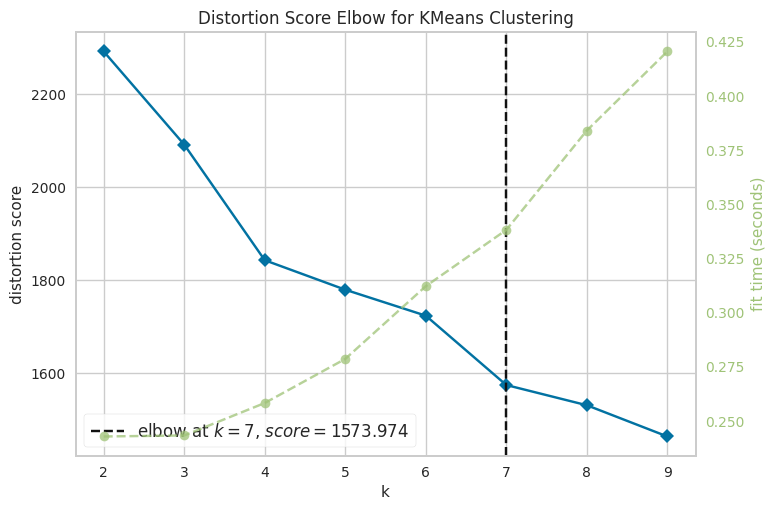

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
## Initialize the clustering model
km = KMeans(random_state = 42, n_init = "auto")
visualizer = KElbowVisualizer(estimator = km , 
                              k = (2,10), 
                              locate_elbow = True)
visualizer.fit(pca_df)
visualizer.show()

The best number of clusters suggested by the algorithm is 7. So, considering 7 as the best number of clusters.

In [41]:
n_clusters = 7
# clusters = KMeans(n_clusters).fit(pca_df)
# print(clusters.inertia_)


In [42]:
## Pickling the model for future use

# import pickle
# with open("kmeans_model.pkl", "wb") as file:
#     pickle.dump(clusters,file)

In [43]:
## Reading the model
import pickle
with open("/kaggle/input/kmeans-model-for-customer-segmentation/scikitlearn/kmeans-model/1/kmeans_model", "rb") as file:
    clusters = pickle.load(file)

In [44]:
clusters_predict = clusters.predict(pca_df)
df["clusters"] = clusters_predict

In [45]:
cluster_counts = df.groupby("clusters")["y"].value_counts().unstack().fillna(0)
print(f"Cluster with Max Yes: {cluster_counts['yes'].idxmax()}")
print(f"Clusters with Max No: {cluster_counts['no'].idxmax()}")

Cluster with Max Yes: 2
Clusters with Max No: 6


In [46]:
cluster_counts

y,no,yes
clusters,,
0,4764,583
1,3200,147
2,5723,1228
3,3711,365
4,769,86
5,4766,917
6,6305,386


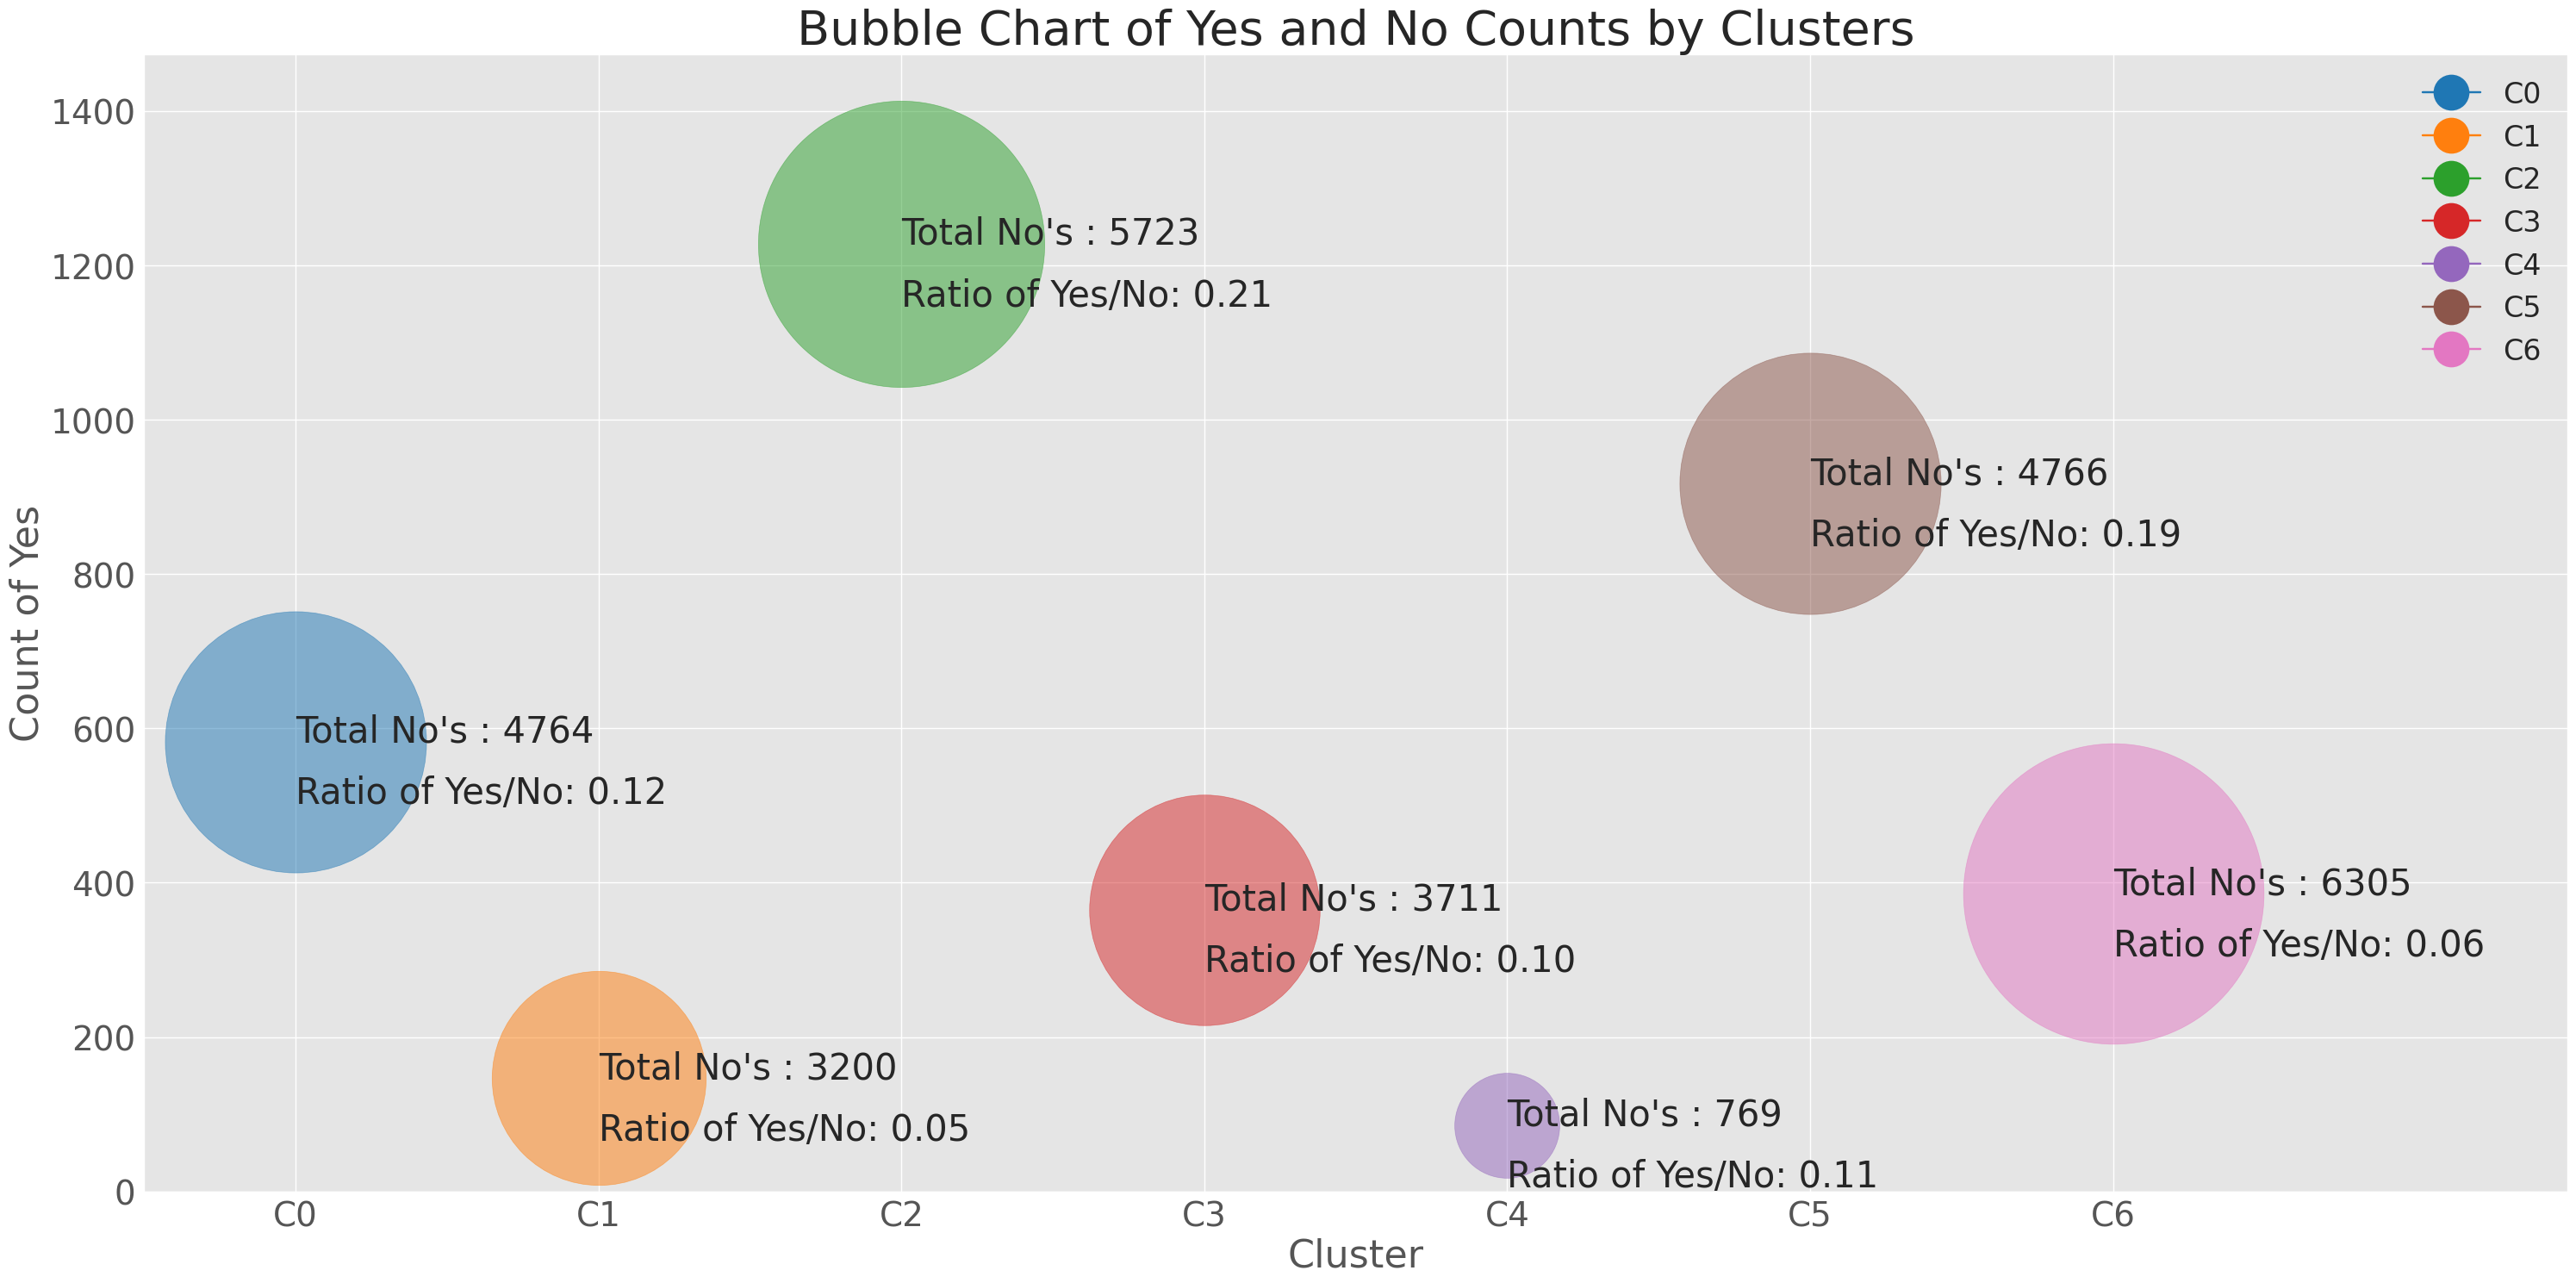

In [47]:
plt.style.use("ggplot")
plt.figure(figsize = (30,15))
colors = plt.cm.tab10.colors[:len(cluster_counts)]

legend_markers = []

for cluster, count, color in zip(cluster_counts.index, 
                                 cluster_counts.values, 
                                 colors):
    marker = plt.Line2D([0], 
                        [0], 
                        linestyle = None, 
                        marker = "o", 
                        markersize = 30,
                        label = f"C{cluster}",
                       color = color)
    legend_markers.append(marker)
    
    plt.scatter(cluster, 
                count[1], 
                s = count[0] * 10,
                alpha = 0.5,
                label = f"Cluster{cluster}",
                color = color
               )
    plt.text(x = cluster, y = count[1], s = f"Total No's : {count[0]}", fontsize = 30)
    plt.text(x = cluster, y = count[1] - 80, s = f"Ratio of Yes/No: {count[1]/count[0]:.2f}", fontsize = 30)
plt.xlabel("Cluster", fontsize = 32)
plt.ylabel("Count of Yes", fontsize = 32)
plt.title("Bubble Chart of Yes and No Counts by Clusters", fontsize = 40)
plt.xticks(ticks = range(n_clusters), fontsize = 28, labels = [f"C{i}" for i in range(n_clusters)]) 
plt.yticks(fontsize = 28)

plt.grid(True)
plt.legend(handles = legend_markers, loc = "upper right", fontsize = 24)

plt.margins(0.1)
plt.xlim(-0.5, len(cluster_counts) + 0.5)
plt.ylim(0, cluster_counts["yes"].max() *1.2)



plt.tight_layout()
plt.show()


**Note:**

The size of the bubbles denotes the total number of customers who didn't subscribe for term deposit

**Key Observations:**

* Cluster 2 has the highest number of subscribers, followed by cluster 5.

* Customers in clusters 1 and 6 exhibit the lowest yes-to-no ratio, indicating that most customers who were followed denied subscribing.

* Although cluster 4 has a small customer base, the conversion ratio is relatively high compared to clusters 1 and 6.

* Target clusters ranked in descending order: 2, 5, 0, 3, 6, 1, and 4. It's advisable to prioritize cluster 3 over 6 due to resource optimization concerns; pursuing cluster 6 would likely consume more resources with a lower probability of yielding positive outcomes.

* Cluster 4 is ranked last because of its small population size, limiting the sample size for justifying resource allocation towards that cluster in terms of return on investment.

## Analysing Each Cluster

**Suggested Cluster Order For Follow Up: 2, 5, 0, 3, 6, 1 and 4**

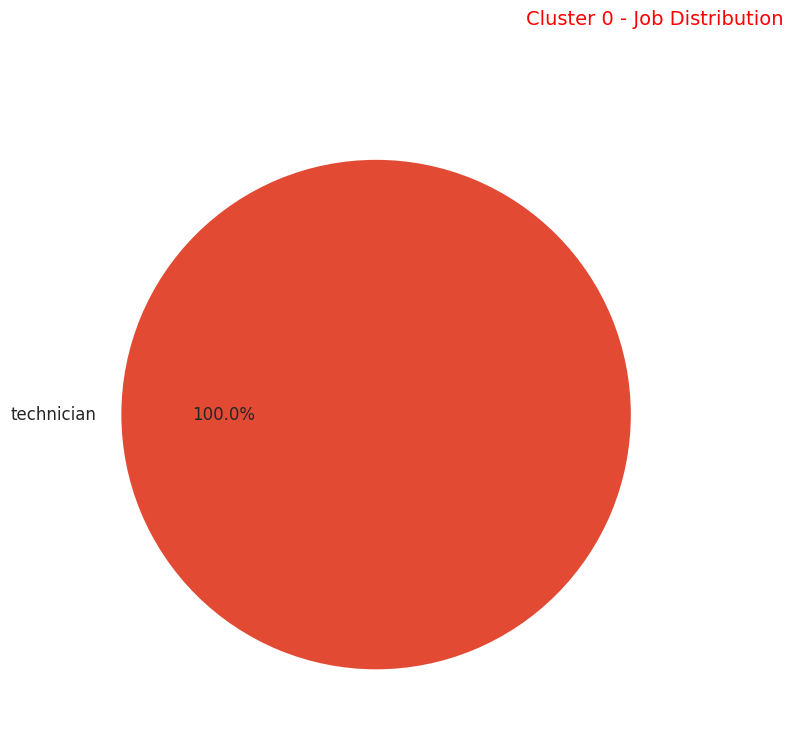

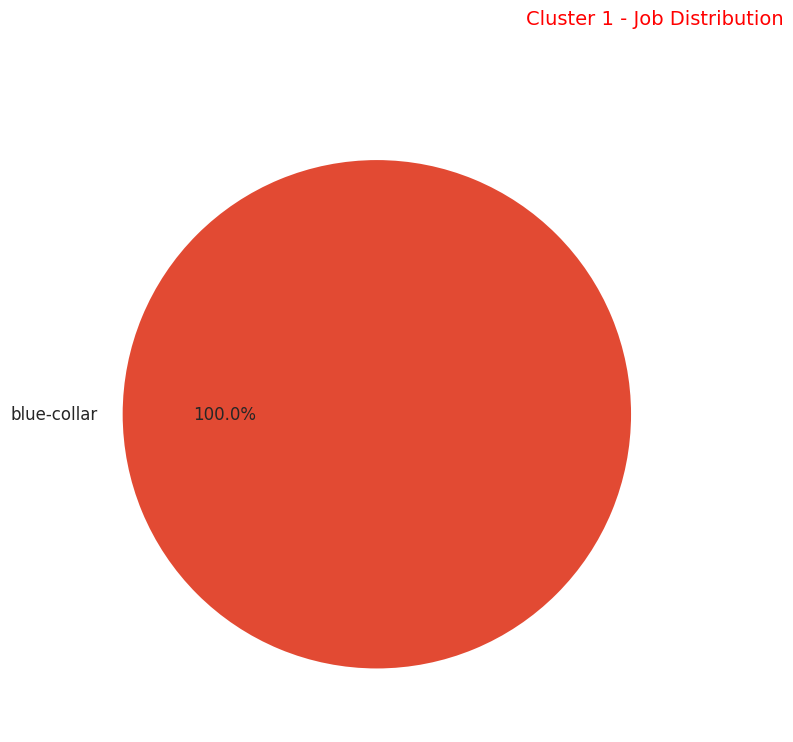

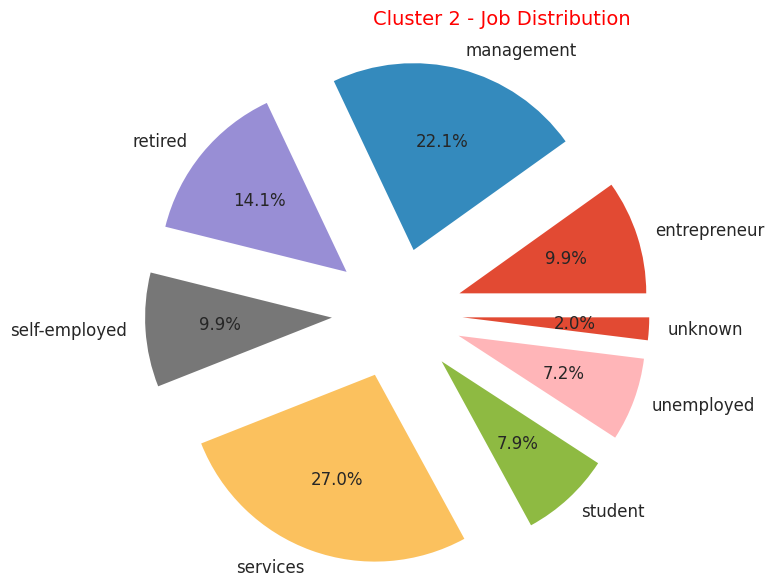

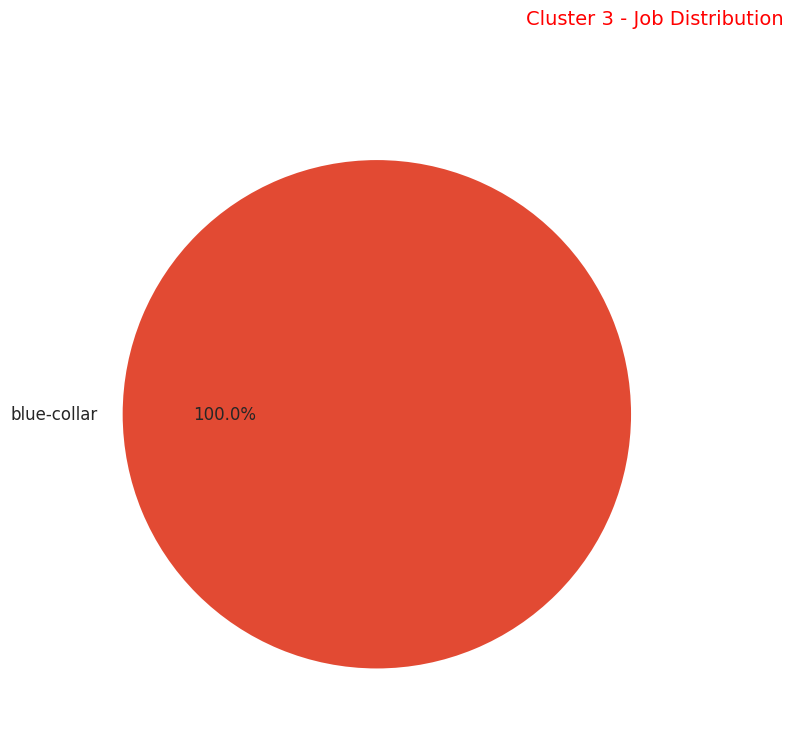

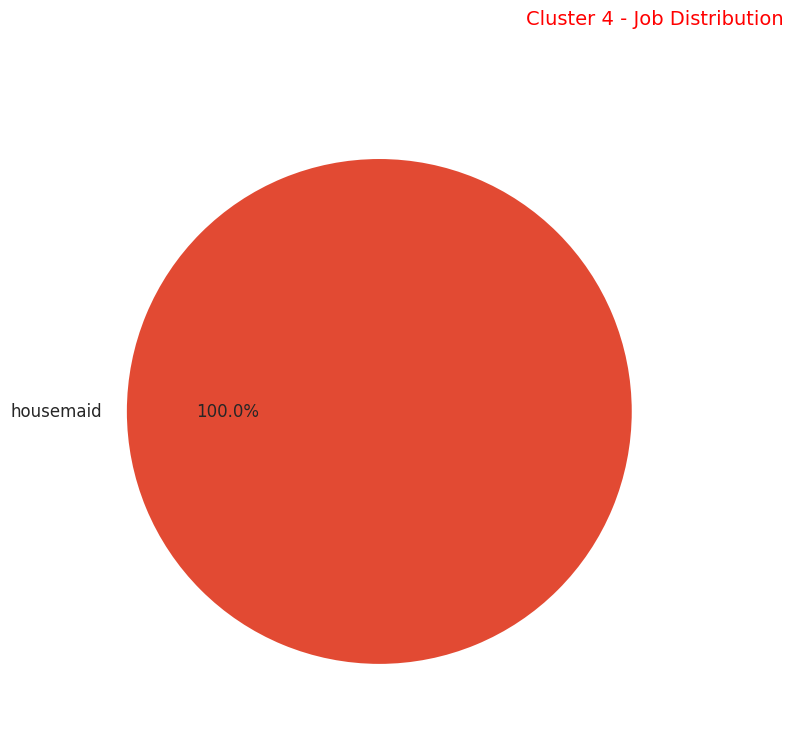

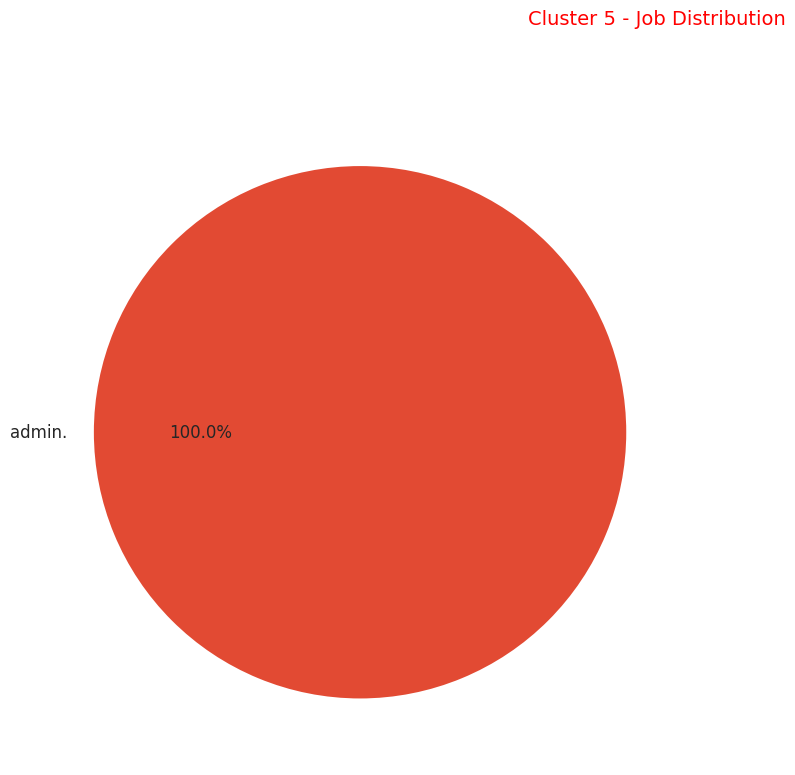

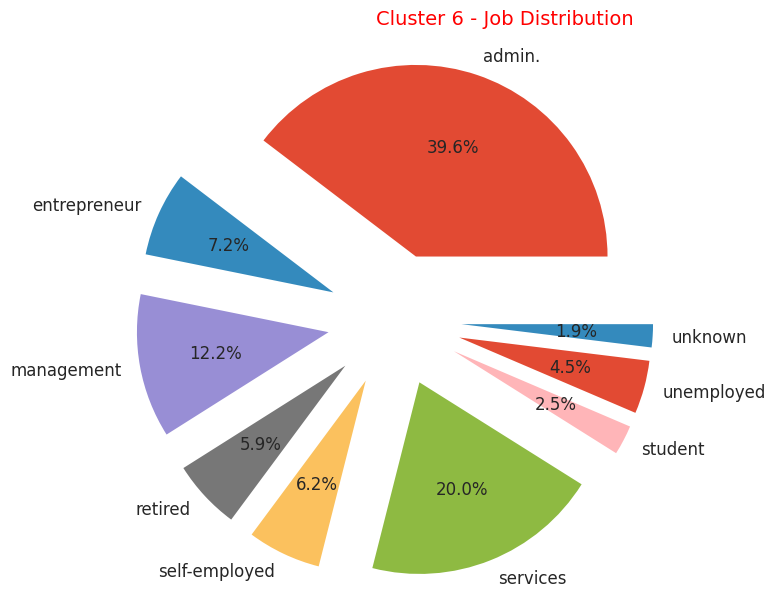

In [48]:
job_clusterwise = df.groupby(['clusters', 'job'])['job'].value_counts()

def plot_pie_chart(cluster_data, 
                   cluster_num, 
                   pct_fontsize = 12, 
                   label_fontsize = 14,threshold_count = 50):
    labels = [job for cluster, 
              job in cluster_data.keys() if cluster == cluster_num]
    sizes = [count for (cluster, job), 
             count in cluster_data.items() if cluster == cluster_num]
    
    
    ## Filter out non zero labels and sizes based on threshold
    non_zero_labels = [label for label, size in zip(labels, sizes) if size>threshold_count]

    non_zero_sizes = [size for size in sizes if size>threshold_count]
    
    
    
    plt.figure(figsize = (8,8))
    plt.pie(non_zero_sizes, 
            labels = non_zero_labels, 
            autopct = "%1.1f%%", 
            textprops = {"fontsize": pct_fontsize},
            labeldistance = 1.1,
            rotatelabels = False, 
            explode = [0.35] * len(non_zero_labels))
    plt.title(f"Cluster {cluster_num} - Job Distribution", 
              fontsize = label_fontsize, 
              loc = "right", 
              y = 1.1, 
              color = "red")
    plt.tight_layout()
    

    plt.show()



## Looping through each cluster
for cluster_num in range(n_clusters):
    plot_pie_chart(job_clusterwise, cluster_num)

    
    
    
    

**Key Observations:**

1. For inclusion in the pie chart, each job category must have more than 50 observations in that particular cluster.

2. Cluster 2, with the highest number of subscribers, predominantly comprises customers working in service-related industries, followed by those in management-related roles.

3. Cluster 5, the second most influential cluster, consists entirely of customers employed in administrative positions.

4. Cluster 0, the third most influential cluster, is comprised entirely of technicians.

5. Cluster 4, the least performing cluster, consists entirely of customers employed as housemaids.

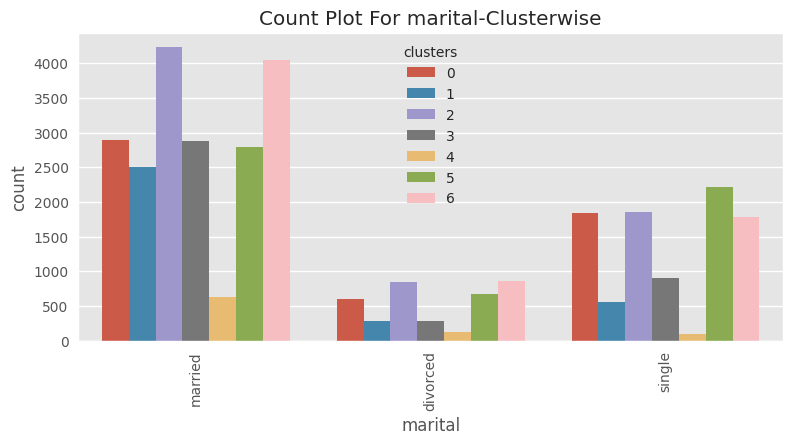

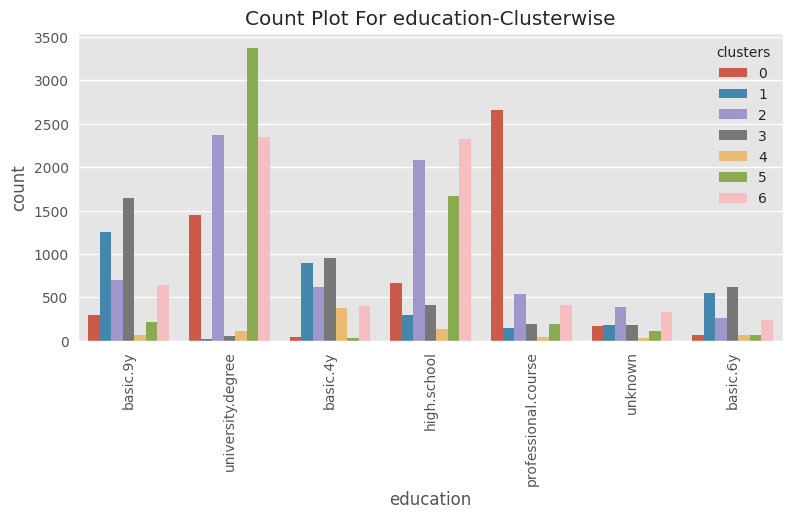

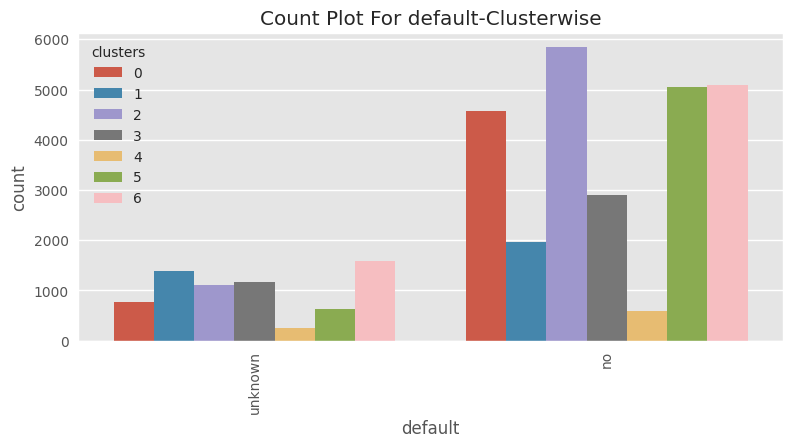

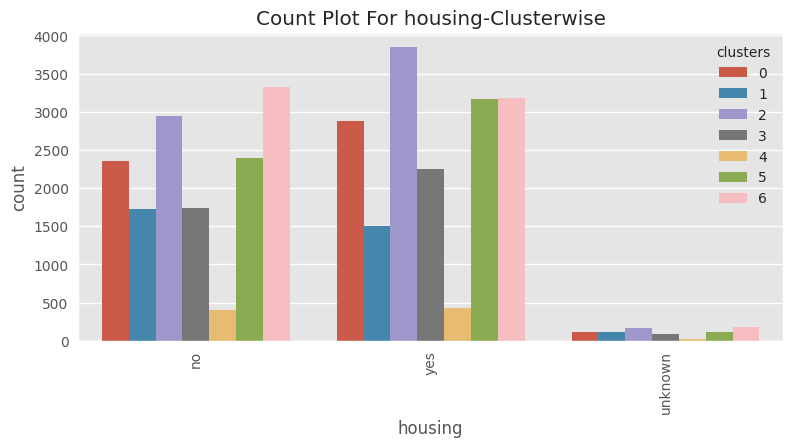

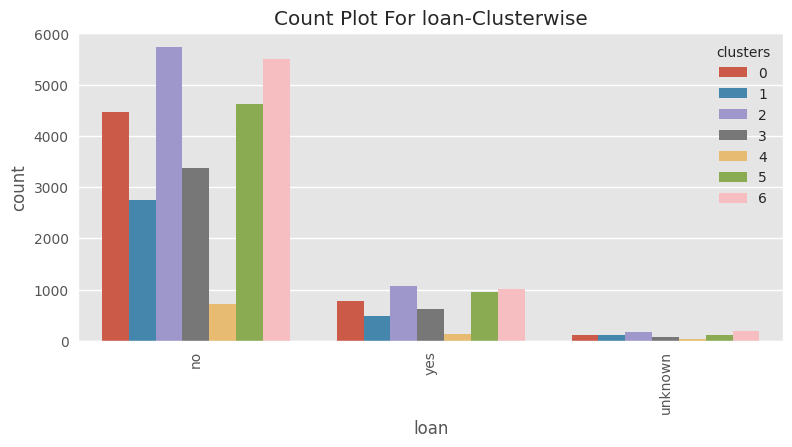

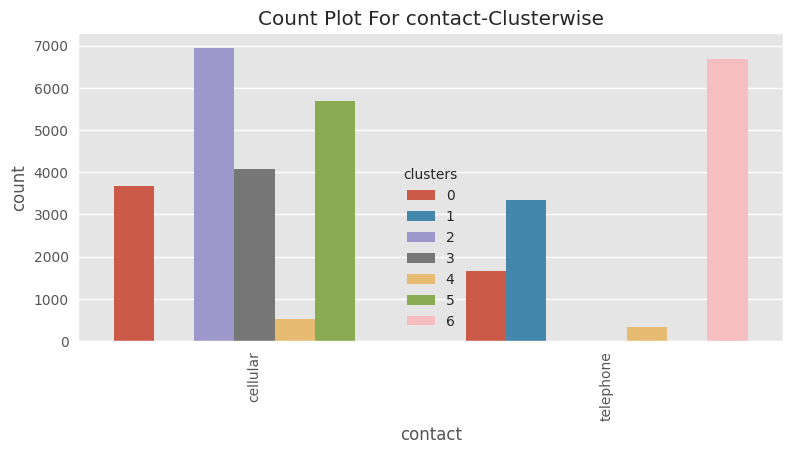

In [49]:
plt.style.use("ggplot")
for col in cat_vars.columns[1:7]:
    plt.figure(figsize = (20,4))
    plt.subplot(121)
    value_counts = df[col].value_counts()
    
    #Filter Valid Categories
    valid_categories = value_counts[value_counts >=100].index
    
    # Filter the dataframe
    df_filtered = df[df[col].isin(valid_categories)]
    
    if not df_filtered.empty:
        ax = sns.countplot(x = df_filtered[col], hue = df_filtered["clusters"])
        plt.title(f"Count Plot For {col}-Clusterwise")
        plt.xticks(rotation = 90)
        plt.show()

**Key Observations**

1. In prominent clusters, most customers are married, followed by singles.

2. Most customers in prominent clusters hold a university degree or have completed at least high school. Customers in cluster 0 are more inclined towards professional courses.

3. The presence of a housing loan does not significantly impact a customer's subscription behavior, unlike personal loans. Customers with personal loans are less likely to subscribe to term deposits.

4. Customers in clusters 1 and 6 were contacted via telephone.

## Summary of all Key Observations

**Key Observation Summary:**

**1. Customer Profile:**
   - Top three professions: Administration, Blue-Collar, Technician.
   - Majority are married with a University Degree.
   - Non-defaulters with housing loans but no personal loans.
   - New targets for marketing campaigns.
   - Majority have not subscribed to a term deposit.

**2. Missing Data & Correlation:**
   - Null values in "housing" and "loan" columns suggest undisclosed loan status.
   - No significant correlation observed among null values in other columns.

**3. Age and Contact Details:**
   - Majority of customers are in their thirties.
   - Right-skewed age distribution with high outliers in duration.
   - Most customers are first-time contacts (pdays value of 999).

**4. Term Deposit Subscription:**
   - Administrative jobs have the highest subscription.
   - Married, university degree holders show higher subscription tendency.
   - Non-defaulters and cellular contacts more likely to subscribe.
   - Months of March, September, October, December have higher subscription rates.
   - Success rates are notably high for students, retired individuals, and illiterate individuals.

**5. Clustering and Targeting:**
   - Duration, Age, and Campaign are numerical columns with outliers.
   - Best number of clusters suggested by the algorithm is 7.
   - Key clusters ranked in descending order: 2, 5, 0, 3, 6, 1, 4.
   - Prioritization based on resource optimization: Cluster 3 over 6; Cluster 4 least priority but shouldn't be dropped as it has good turn in ratio compared to 1 and 6.

**6. Job Category Observations:**
   - Each job category in a cluster must have >50 observations for pie chart inclusion.
   - Cluster 2: Highest subscribers, service-related industries dominate.
   - Cluster 5: Administrative positions dominate.
   - Cluster 0: Technicians exclusively.
   - Cluster 4: Least performing, housemaids exclusively but good turn in rate compared to C1 and C6. Just the number of customers in this category is pretty less.

**7. Marital Status and Education:**
   - Marital status: Married, singles prominent in clusters.
   - Education: University degree or at least high school, cluster 0 more professional-oriented.

**8. Loan Impact on Subscription:**
   - Housing loans have minimal impact; personal loans deter subscription.
   - Customers in clusters 1 and 6 were contacted via telephone.

### We can use the Kmeans Model to Predict Any Future Target Customer and Prioritize our Follow Up Accordingly